# ROBUST INFERENCE OF VOLATILITY ROUGHNESS

In [8]:
import os
os.listdir(r"daily_csv")


['spy_2020-03-24.csv',
 'spy_2022-12-22.csv',
 'spy_2020-03-30.csv',
 'spy_2020-03-18.csv',
 'spy_2021-05-26.csv',
 'spy_2019-10-11.csv',
 'spy_2021-12-02.csv',
 'spy_2021-12-16.csv',
 'spy_2022-05-12.csv',
 'spy_2022-05-06.csv',
 'spy_2019-09-18.csv',
 'spy_2019-09-24.csv',
 'spy_2019-07-09.csv',
 'spy_2019-09-30.csv',
 'spy_2022-09-06.csv',
 'spy_2021-10-07.csv',
 'spy_2020-11-30.csv',
 'spy_2021-10-13.csv',
 'spy_2022-09-12.csv',
 'spy_2020-11-24.csv',
 'spy_2020-11-18.csv',
 'spy_2019-05-30.csv',
 'spy_2019-05-24.csv',
 'spy_2019-02-05.csv',
 'spy_2019-02-11.csv',
 'spy_2020-08-05.csv',
 'spy_2020-01-21.csv',
 'spy_2020-08-11.csv',
 'spy_2022-10-27.csv',
 'spy_2021-07-23.csv',
 'spy_2020-01-09.csv',
 'spy_2020-01-08.csv',
 'spy_2020-06-01.csv',
 'spy_2020-06-15.csv',
 'spy_2021-07-22.csv',
 'spy_2021-09-27.csv',
 'spy_2022-10-26.csv',
 'spy_2020-08-10.csv',
 'spy_2020-06-29.csv',
 'spy_2020-08-04.csv',
 'spy_2019-02-04.csv',
 'spy_2019-05-31.csv',
 'spy_2020-11-19.csv',
 'spy_2020-

## First Approach


  $$
  \hat c^{n,k_n}*i ;=; \frac{1}{k_n\varepsilon_n}\sum*{j=i}^{i+k_n-1} (\Delta y_j)^2 \mathbf{1}_{{|\Delta y_j|\le v_n}},
  $$


In [9]:
import polars as pl
from pathlib import Path
from datetime import date

##############################
### REMOVING FOLLOWING DATES #
##############################

FOMC_announcement = [
    "2012-01-25","2012-03-13","2012-04-25","2012-06-20","2012-08-01","2012-09-13","2012-10-24","2012-12-12",
    "2013-01-30","2013-03-20","2013-05-01","2013-06-19","2013-07-31","2013-09-18","2013-10-30","2013-12-18",
    "2014-01-29","2014-03-19","2014-04-30","2014-06-18","2014-07-30","2014-09-17","2014-10-29","2014-12-17",
    "2015-01-28","2015-03-18","2015-04-29","2015-06-17","2015-07-29","2015-09-17","2015-10-28","2015-12-16",
    "2016-01-27","2016-03-16","2016-04-27","2016-06-15","2016-07-27","2016-09-21","2016-11-02","2016-12-14",
    "2017-02-01","2017-03-15","2017-05-03","2017-06-14","2017-07-26","2017-09-20","2017-11-01","2017-12-13",
    "2018-01-31","2018-03-21","2018-05-02","2018-06-13","2018-08-01","2018-09-26","2018-11-08","2018-12-19",
    "2019-01-30","2019-03-20","2019-05-01","2019-06-19","2019-07-31","2019-09-18","2019-10-30","2019-12-11",
    "2020-01-29","2020-04-29","2020-06-10","2020-07-29","2020-09-16","2020-11-05","2020-12-16",
    "2021-01-27","2021-03-17","2021-04-28","2021-06-16","2021-07-28","2021-09-22","2021-11-03","2021-12-15",
    "2022-01-26","2022-03-16","2022-05-04","2022-06-15","2022-07-27","2022-09-21","2022-11-02","2022-12-14",
]
trading_halt = [
    '2013-07-03','2013-11-29','2013-12-24',
    '2014-07-03','2014-10-30','2014-11-28','2014-12-24',
    '2015-11-27','2015-12-24',
    '2016-11-25',
    '2017-07-03','2017-11-24',
    '2018-07-03','2018-11-23','2018-12-24',
    "2019-07-03","2019-08-12","2019-11-29","2019-12-24",
    "2020-03-09","2020-03-12","2020-03-16","2020-03-18","2020-11-27","2020-12-24",
    "2021-05-05","2022-11-26","2022-11-25"
]
EXCLUDE_DATES = {date.fromisoformat(s) for s in FOMC_announcement} | {date.fromisoformat(s) for s in trading_halt}

###################################################
### READING DATA USING POLARS #####################
###################################################

def load_daily_dir_to_polars(
    dir_path: str | Path = "daily_csv",
    *,
    dt_col: str = "DT",
    px_col: str = "Price",
) -> pl.DataFrame:
    """
    Reads all CSVs in dir_path with columns [DT, Price], returns a single
    Polars DataFrame with standardized columns ['timestamp','price'].
    Skips empty/iCloud placeholder files (size == 0).
    """
    dir_path = Path(dir_path)
    files = sorted(p for p in dir_path.glob("*.csv") if p.is_file() and p.stat().st_size > 0)
    if not files:
        raise FileNotFoundError(f"No non-empty CSV files in {dir_path.resolve()}")

    
    lfs = []
    for p in files:
        lf = (
            pl.scan_csv(
                p,
                has_header=True,
                infer_schema_length=0,  
                ignore_errors=True
            )
            .select([pl.col(dt_col).alias("DT"), pl.col(px_col).cast(pl.Float64).alias("Price")])
            .with_columns([
                # Parse DT to Datetime (auto-detects common formats; tolerant)
                pl.col("DT").str.strptime(pl.Datetime, strict=False).alias("timestamp"),
                pl.col("Price").alias("price"),
            ])
            .select(["timestamp","price"])
        )
        lfs.append(lf)

    df = (
        pl.concat(lfs, how="vertical_relaxed")
        .drop_nulls(["timestamp","price"])
        .unique(subset=["timestamp"], keep="last")
        .sort("timestamp")
        .collect(streaming=True)   
        .rechunk()
    )
    return df

##########################################################################
############ JUMP TRUNCATION #############################################
##########################################################################

def infer_eps_seconds(df: pl.DataFrame, ts_col: str = "timestamp") -> float:
    """Infer ε_n (seconds) from median spacing within each day."""
    return float(
        df
        .with_columns(pl.col(ts_col).dt.date().alias("date"))
        .group_by("date")
        .agg(pl.col(ts_col).diff().drop_nulls().alias("dts"))
        .explode("dts")
        .select(pl.col("dts").dt.total_seconds().alias("sec"))
        .select(pl.median("sec").alias("eps"))
        .item()
    )

def filter_jumps_paper_threshold(
    df: pl.DataFrame,
    *,
    ts_col: str = "timestamp",
    px_col: str = "price",
    gamma: float = 0.49,
    kappa: float = 8.0,
    eps_seconds: float | None = None,
    drop_excluded_days: bool = True,
):
    """
    Apply |Δy| <= v_n with v_n = kappa * ε_n^gamma (microstructure ignored).
    Returns (out_df, clean_df, v_n, eps_seconds).
    out_df keeps rows and sets jump returns to NULL in 'ret_nojump';
    clean_df drops jump increments entirely.
    """
    df0 = df
    if drop_excluded_days:
        df0 = (
            df0
            .with_columns(pl.col(ts_col).dt.date().alias("date"))
            .filter(~pl.col("date").is_in(list(EXCLUDE_DATES)))
            .drop("date")
        )

    if eps_seconds is None:
        eps_seconds = infer_eps_seconds(df0, ts_col)

    df1 = (
        df0
        .with_columns([
            pl.col(ts_col).dt.date().alias("date"),
            pl.col(px_col).log().alias("logp"),
        ])
        .with_columns([
            pl.when(pl.col("date") == pl.col("date").shift(1))
              .then(pl.col("logp") - pl.col("logp").shift(1))
              .otherwise(None)
              .alias("ret")
        ])
    )

    v_n = kappa * (eps_seconds ** gamma)

    out = (
        df1
        .with_columns([
            pl.col("ret").abs().alias("abs_ret"),
            pl.lit(v_n).alias("v_n"),
            (pl.col("ret").abs() > v_n).alias("is_jump"),
            pl.when(pl.col("ret").abs() > v_n).then(None).otherwise(pl.col("ret")).alias("ret_nojump")
        ])
    )
    clean = out.filter(~pl.col("is_jump").fill_null(False))
    return out, clean, v_n, eps_seconds

############################################
############ RUN ###########################
############################################

df = load_daily_dir_to_polars("daily_csv")
print(df.head())
print(df.schema)


out_df, clean_df, v_n, eps = filter_jumps_paper_threshold(
    df,
    ts_col="timestamp",
    px_col="price",
    gamma=0.49,      
    kappa=8.0,       
    eps_seconds=None,
    drop_excluded_days=True
)

print(f"ε_n (seconds) = {eps:.6g} | v_n = {v_n:.6g}")


summary = (
    out_df
    .select([
        pl.col("timestamp").dt.date().alias("date"),
        pl.col("is_jump")
    ])
    .group_by("date")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("is_jump").sum().fill_null(0).alias("n_jumps")
    ])
    .sort("date")
    .tail(15)
)
print(summary)


/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_6541/660651535.py:76: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  pl.concat(lfs, how="vertical_relaxed")


shape: (5, 2)
┌─────────────────────┬────────┐
│ timestamp           ┆ price  │
│ ---                 ┆ ---    │
│ datetime[μs]        ┆ f64    │
╞═════════════════════╪════════╡
│ 2019-01-02 09:30:01 ┆ 246.02 │
│ 2019-01-02 09:30:02 ┆ 246.04 │
│ 2019-01-02 09:30:03 ┆ 246.01 │
│ 2019-01-02 09:30:04 ┆ 245.99 │
│ 2019-01-02 09:30:05 ┆ 245.99 │
└─────────────────────┴────────┘
Schema([('timestamp', Datetime(time_unit='us', time_zone=None)), ('price', Float64)])
ε_n (seconds) = 1 | v_n = 8
shape: (15, 3)
┌────────────┬───────┬─────────┐
│ date       ┆ n_obs ┆ n_jumps │
│ ---        ┆ ---   ┆ ---     │
│ date       ┆ u32   ┆ u32     │
╞════════════╪═══════╪═════════╡
│ 2022-12-08 ┆ 23400 ┆ 0       │
│ 2022-12-09 ┆ 23400 ┆ 0       │
│ 2022-12-12 ┆ 23400 ┆ 0       │
│ 2022-12-13 ┆ 23400 ┆ 0       │
│ 2022-12-15 ┆ 23400 ┆ 0       │
│ …          ┆ …     ┆ …       │
│ 2022-12-23 ┆ 23400 ┆ 0       │
│ 2022-12-27 ┆ 23400 ┆ 0       │
│ 2022-12-28 ┆ 23400 ┆ 0       │
│ 2022-12-29 ┆ 23400 ┆ 0       │

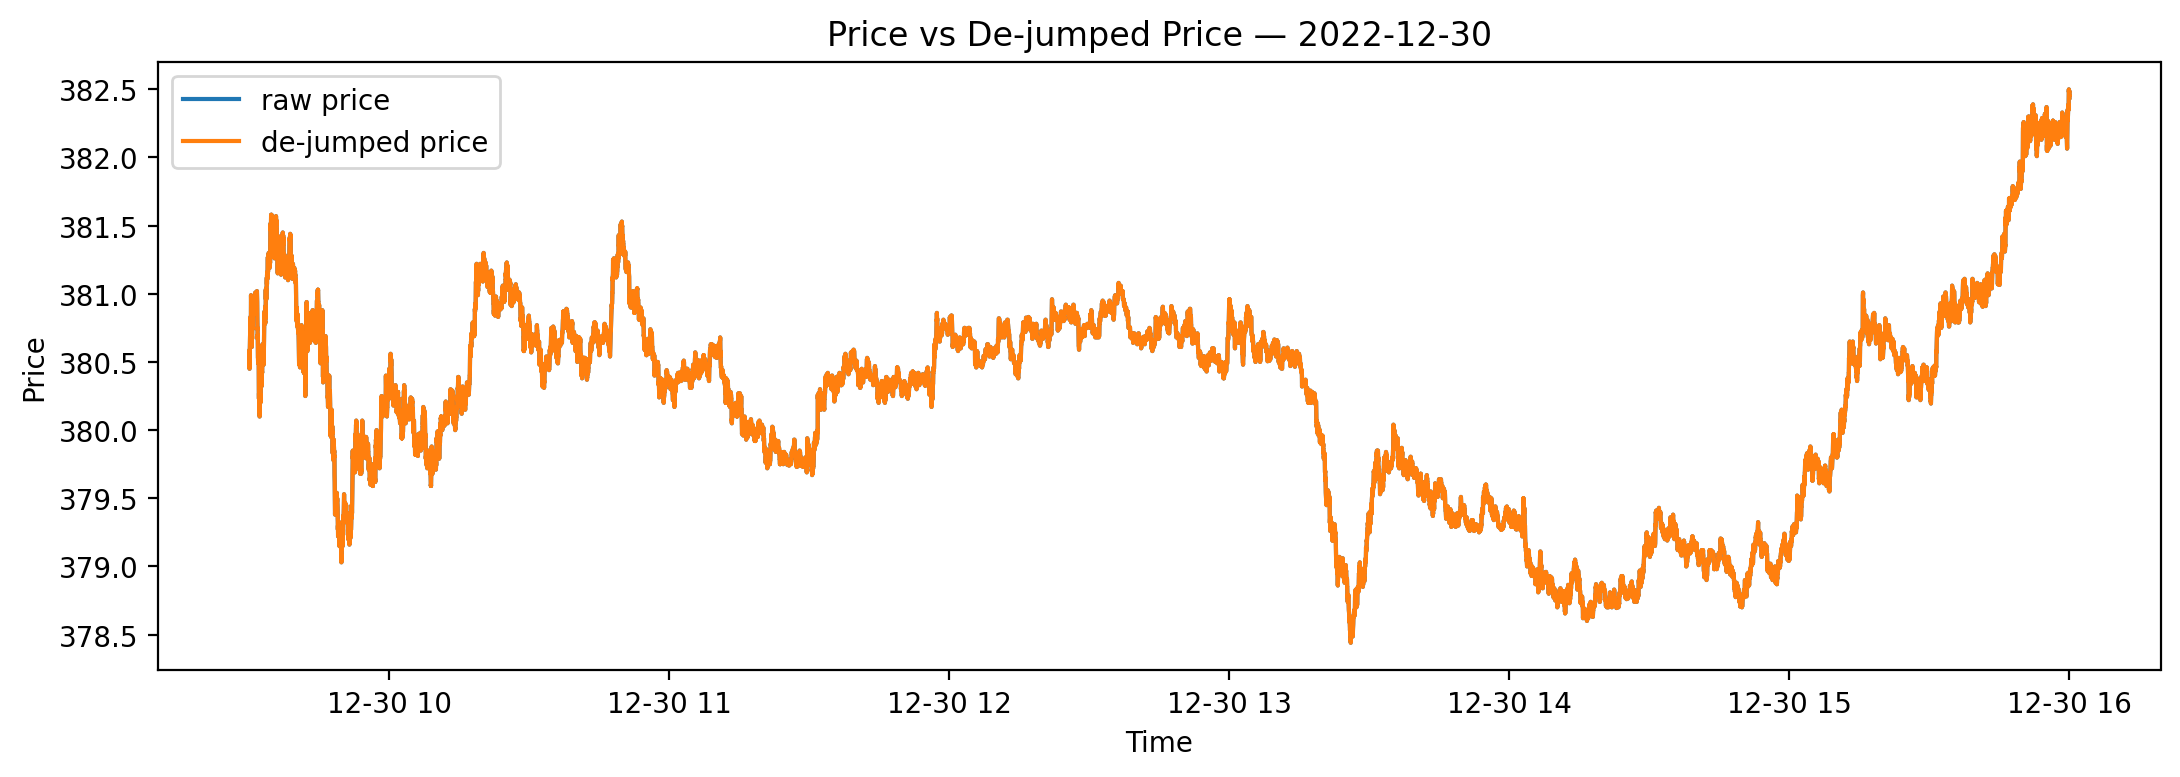

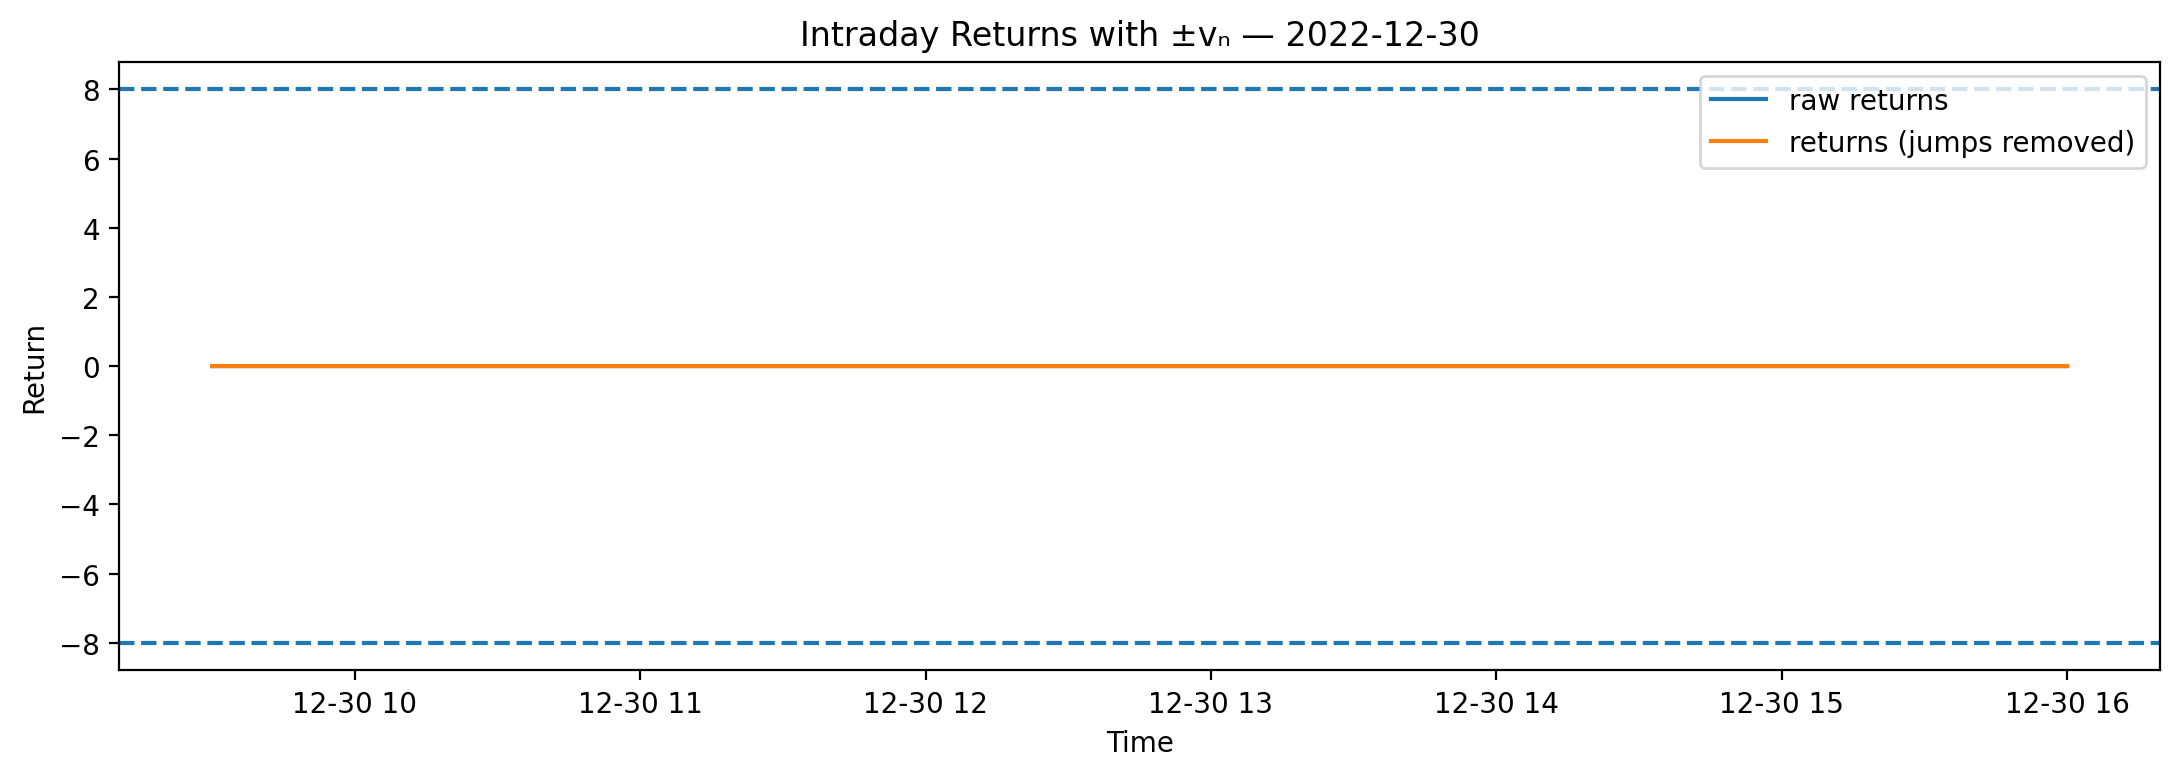

In [10]:
###############################################################
############################## PLOT ###########################
###############################################################

import matplotlib.pyplot as plt
from datetime import date as _pydate

plot_df = (
    out_df
    .with_columns([
        pl.col("timestamp").dt.date().alias("date"),
        pl.col("ret_nojump").fill_null(0.0).alias("ret_nj0"),
    ])
    .with_columns([
        pl.col("ret_nj0").cum_sum().over("date").alias("cs_ret_nj0"),
        pl.first("logp").over("date").alias("logp0"),
    ])
    .with_columns([
        (pl.col("logp0") + pl.col("cs_ret_nj0")).exp().alias("price_nojump")
    ])
    .select(["timestamp", "date", "price", "price_nojump", "ret", "ret_nojump", "is_jump", "v_n"])
    .sort("timestamp")
)


_last_day = plot_df.select(pl.max("date")).item()
DAY = str(_last_day)  
_day = _pydate.fromisoformat(DAY)

day_view = (
    plot_df
    .filter(pl.col("date") == pl.lit(_day))
    .select(["timestamp","price","price_nojump","ret","ret_nojump","is_jump","v_n"])
    .to_pandas()
)


plt.figure(figsize=(11,4))
plt.plot(day_view["timestamp"], day_view["price"], label="raw price")
plt.plot(day_view["timestamp"], day_view["price_nojump"], label="de-jumped price")
plt.title(f"Price vs De-jumped Price — {DAY}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(11,4))
plt.plot(day_view["timestamp"], day_view["ret"], label="raw returns")
plt.plot(day_view["timestamp"], day_view["ret_nojump"], label="returns (jumps removed)")
if len(day_view) > 0:
    _vn = float(day_view["v_n"].iloc[0])
    plt.axhline(y=_vn, linestyle="--")
    plt.axhline(y=-_vn, linestyle="--")

if "is_jump" in day_view.columns:
    jump_idx = day_view["is_jump"] == True
    if jump_idx.any():
        plt.scatter(day_view.loc[jump_idx, "timestamp"],
                    day_view.loc[jump_idx, "ret"],
                    marker="x")
plt.title(f"Intraday Returns with ±vₙ — {DAY}")
plt.xlabel("Time")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
############################################################
################## SANITY CHECKS ###########################
############################################################

TOL = 1e-12  


base = out_df.filter(pl.col("ret").is_not_null())


false_neg = base.filter(~pl.col("is_jump") & (pl.col("abs_ret") > pl.col("v_n") + TOL)).height
false_pos = base.filter(pl.col("is_jump") & (pl.col("abs_ret") <= pl.col("v_n") - TOL)).height


mismatch_keep = base.filter(
    (~pl.col("is_jump")) &
    ((pl.col("ret_nojump") - pl.col("ret")).abs() > TOL)
).height

mismatch_drop = base.filter(
    (pl.col("is_jump")) & pl.col("ret_nojump").is_not_null()
).height


max_kept_minus_vn = float(
    base.filter(~pl.col("is_jump"))
        .select((pl.max("abs_ret") - pl.first("v_n")).alias("diff"))
        .item()
)


present_excluded_days = (
    out_df
    .select(pl.col("timestamp").dt.date().alias("date"))
    .unique()
    .filter(pl.col("date").is_in(list(EXCLUDE_DATES)))
    .height
)

print("=== Sanity: logical constraints ===")
print(f"False negatives (kept but |ret|>v_n): {false_neg}")
print(f"False positives (flagged jump but |ret|<=v_n): {false_pos}")
print(f"Mismatch kept (ret_nojump ≠ ret when not a jump): {mismatch_keep}")
print(f"Mismatch dropped (ret_nojump not NULL on a jump): {mismatch_drop}")
print(f"Max(|ret| among kept) - v_n: {max_kept_minus_vn:.3e}")
print(f"Excluded days still present: {present_excluded_days}")

assert false_neg == 0, "Some big returns were NOT flagged as jumps."
assert false_pos == 0, "Some flagged jumps are not actually > v_n."
assert mismatch_keep == 0, "ret_nojump must equal ret on non-jump rows."
assert mismatch_drop == 0, "ret_nojump must be NULL on jump rows."
assert max_kept_minus_vn <= TOL, "A kept return exceeds v_n."
assert present_excluded_days == 0, "Some excluded calendar dates remain."

dropped_share = float(
    base.select(pl.col("is_jump").fill_null(False).mean().alias("share_dropped")).item()
)
print("\n=== Diagnostics ===")
print(f"Share of increments dropped as jumps: {dropped_share:.4%}")

q = (
    base.select([
        pl.col("ret").abs().quantile(0.999).alias("q999_raw"),
        pl.col("ret_nojump").abs().quantile(0.999).alias("q999_trunc"),
        pl.col("abs_ret").max().alias("max_abs_raw"),
    ])
    .to_dicts()[0]
)
print(f"abs(ret) 99.9% quantile: raw={q['q999_raw']:.3e}  |  truncated={q['q999_trunc']:.3e}")
print(f"abs(ret) max (raw): {q['max_abs_raw']:.3e}   |  v_n={v_n:.3e}")

rv_daily = (
    out_df
    .select([
        pl.col("timestamp").dt.date().alias("date"),
        (pl.col("ret")**2).alias("rv_raw"),
        (pl.col("ret_nojump")**2).alias("rv_trunc")
    ])
    .group_by("date")
    .agg([
        pl.sum("rv_raw").alias("RV_raw"),
        pl.sum("rv_trunc").alias("RV_trunc"),
    ])
    .with_columns((pl.col("RV_trunc") / pl.col("RV_raw")).alias("ratio"))
    .sort("date")
)

rv_stats = rv_daily.select([
    pl.col("ratio").mean().alias("mean_ratio"),
    pl.col("ratio").quantile(0.1).alias("p10"),
    pl.col("ratio").quantile(0.5).alias("p50"),
    pl.col("ratio").quantile(0.9).alias("p90"),
]).to_dicts()[0]

print("\n=== Realized-variance check (RV_trunc / RV_raw) ===")
print(f"mean={rv_stats['mean_ratio']:.3f} | p10={rv_stats['p10']:.3f} | "
      f"p50={rv_stats['p50']:.3f} | p90={rv_stats['p90']:.3f}")

jump_summary = (
    out_df
    .select([
        pl.col("timestamp").dt.date().alias("date"),
        pl.col("is_jump")
    ])
    .group_by("date")
    .agg([
        pl.len().alias("n_obs"),
        pl.col("is_jump").sum().fill_null(0).cast(pl.Int64).alias("n_jumps")
    ])
    .with_columns((pl.col("n_jumps") / pl.col("n_obs")).alias("jump_rate"))
    .sort("jump_rate", descending=True)
    .head(10)
)
print("\nTop-10 days by jump rate:")
print(jump_summary)

impact_summary = (
    rv_daily
    .with_columns((1 - pl.col("ratio")).alias("rv_reduction"))
    .sort("rv_reduction", descending=True)
    .head(10)
)
print("\nTop-10 days by RV reduction:")
print(impact_summary)


=== Sanity: logical constraints ===
False negatives (kept but |ret|>v_n): 0
False positives (flagged jump but |ret|<=v_n): 0
Mismatch kept (ret_nojump ≠ ret when not a jump): 0
Mismatch dropped (ret_nojump not NULL on a jump): 0
Max(|ret| among kept) - v_n: -7.995e+00
Excluded days still present: 0

=== Diagnostics ===
Share of increments dropped as jumps: 0.0000%
abs(ret) 99.9% quantile: raw=5.250e-04  |  truncated=5.250e-04
abs(ret) max (raw): 4.530e-03   |  v_n=8.000e+00

=== Realized-variance check (RV_trunc / RV_raw) ===
mean=1.000 | p10=1.000 | p50=1.000 | p90=1.000

Top-10 days by jump rate:
shape: (10, 4)
┌────────────┬───────┬─────────┬───────────┐
│ date       ┆ n_obs ┆ n_jumps ┆ jump_rate │
│ ---        ┆ ---   ┆ ---     ┆ ---       │
│ date       ┆ u32   ┆ i64     ┆ f64       │
╞════════════╪═══════╪═════════╪═══════════╡
│ 2019-01-02 ┆ 23400 ┆ 0       ┆ 0.0       │
│ 2019-01-03 ┆ 23400 ┆ 0       ┆ 0.0       │
│ 2019-01-04 ┆ 23400 ┆ 0       ┆ 0.0       │
│ 2019-01-07 ┆ 2340

## Second Approach

/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_6541/3588109710.py:69: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  pl.concat(lfs, how="vertical_relaxed")


shape: (5, 2)
┌─────────────────────┬────────┐
│ timestamp           ┆ price  │
│ ---                 ┆ ---    │
│ datetime[μs]        ┆ f64    │
╞═════════════════════╪════════╡
│ 2019-01-02 09:30:01 ┆ 246.02 │
│ 2019-01-02 09:30:02 ┆ 246.04 │
│ 2019-01-02 09:30:03 ┆ 246.01 │
│ 2019-01-02 09:30:04 ┆ 245.99 │
│ 2019-01-02 09:30:05 ┆ 245.99 │
└─────────────────────┴────────┘
Schema([('timestamp', Datetime(time_unit='us', time_zone=None)), ('price', Float64)])
ε_n (seconds) inferred = 1 | (temporary) v_n = 1
Calibrated kappa @ alpha=0.0010 -> kappa = 0.000525035
Final v_n = 0.000525035 (using calibrated kappa)
=== Sanity: logical constraints ===
False negatives (kept but |ret|>v_n): 0
False positives (flagged jump but |ret|<=v_n): 0
Mismatch kept (ret_nojump ≠ ret when not a jump): 0
Mismatch dropped (ret_nojump not NULL on a jump): 0
Max(|ret| among kept) - v_n: 0.000e+00
Excluded days still present: 0

=== Diagnostics ===
Share of increments dropped as jumps: 0.1000%
abs(ret) 99.9% qua

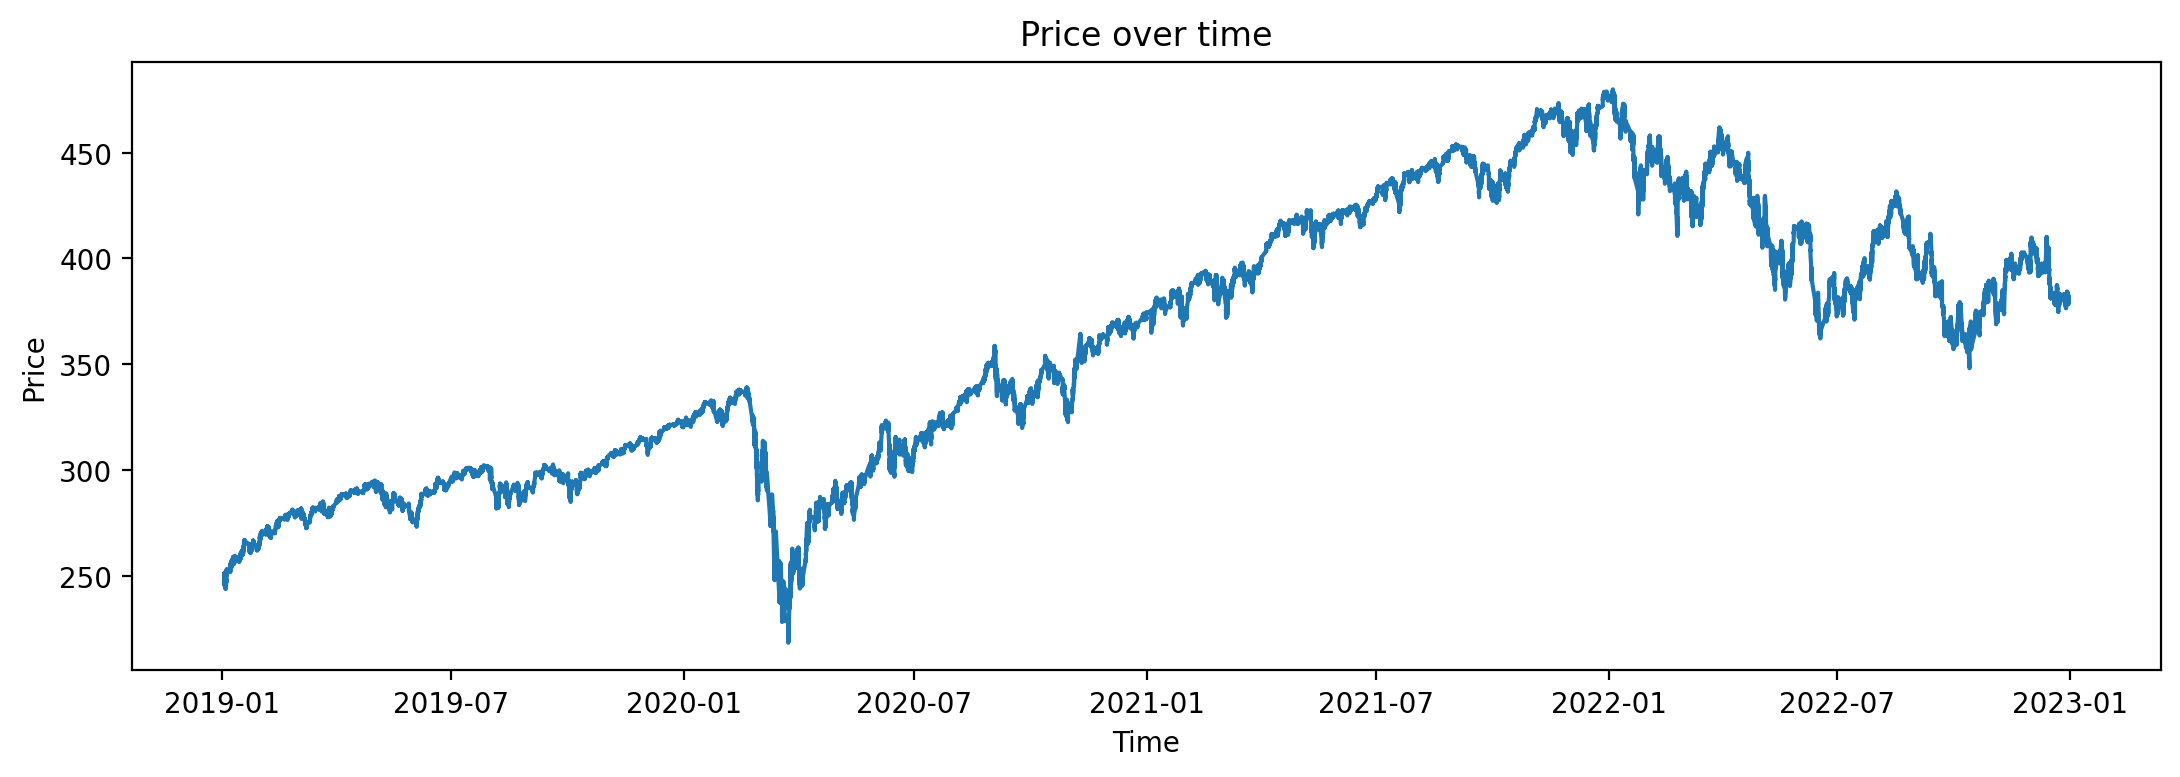

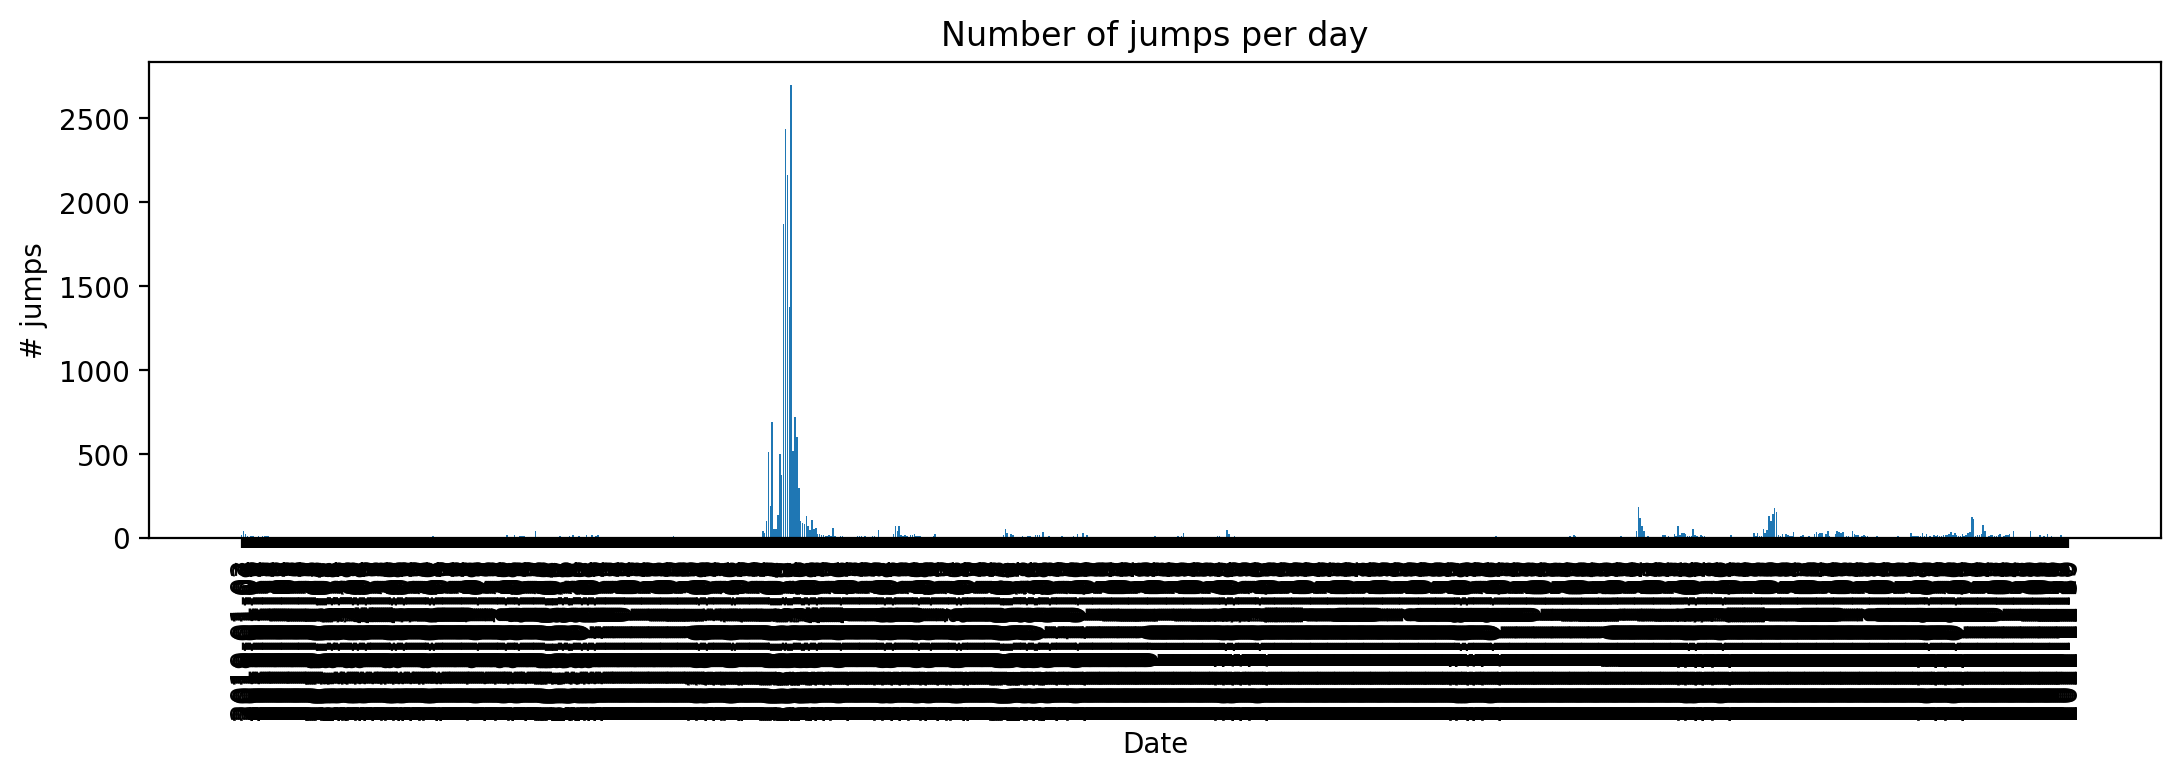

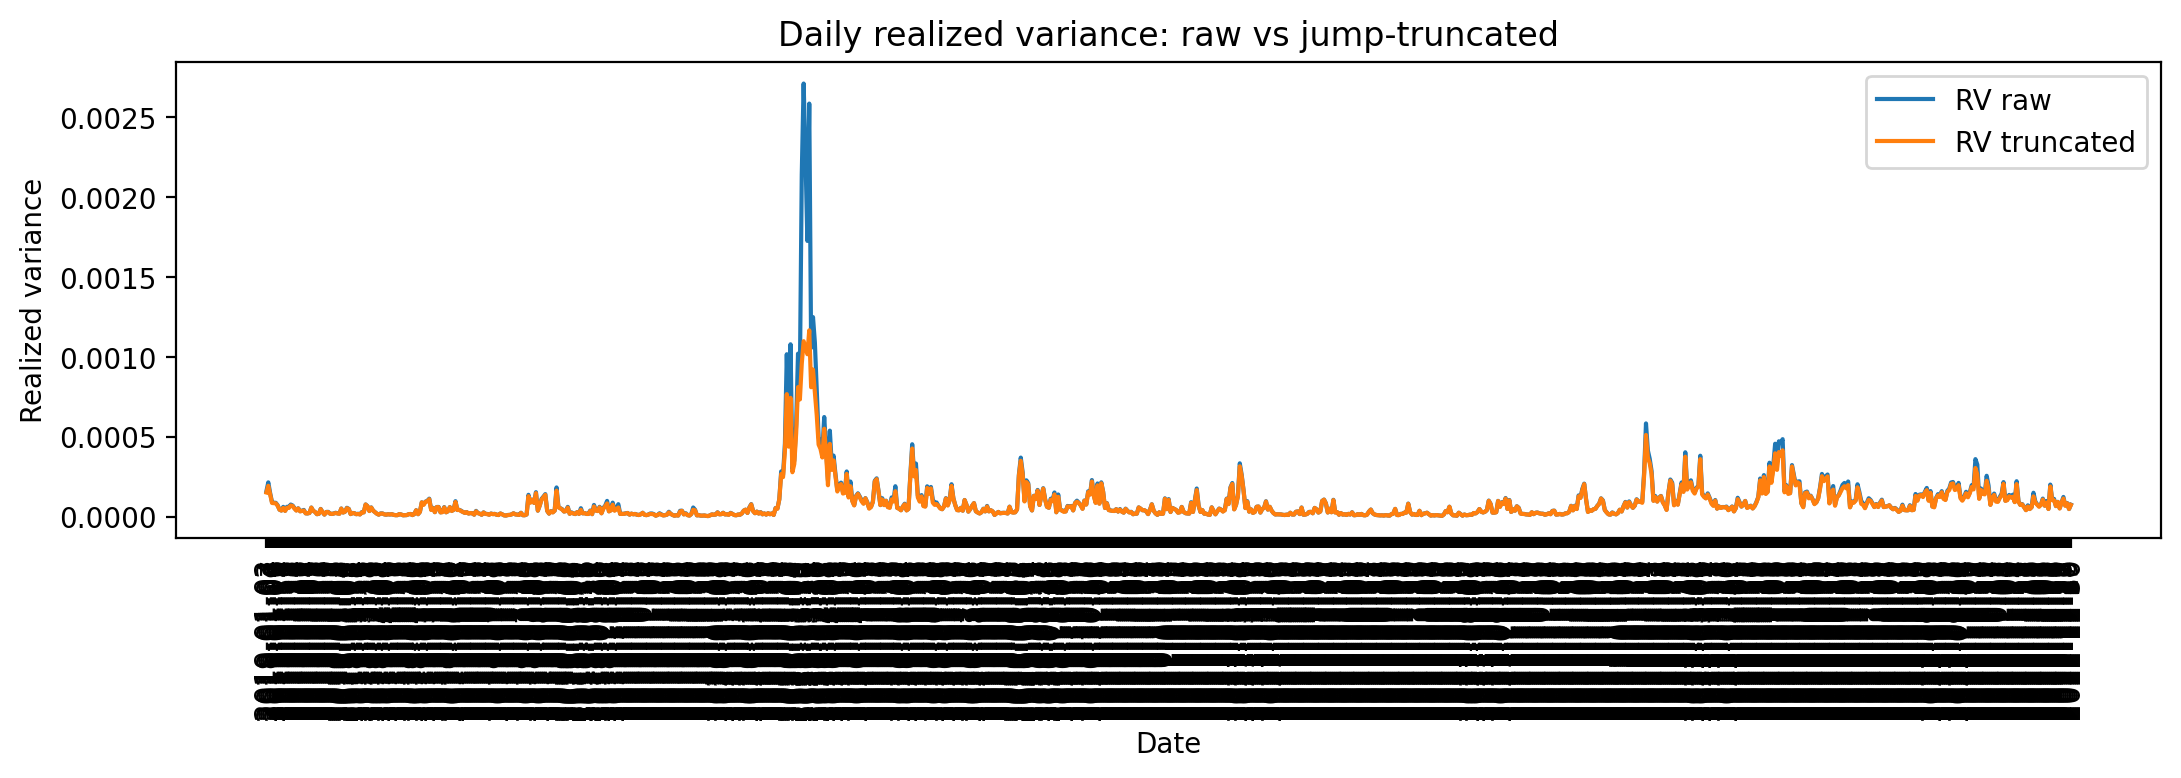

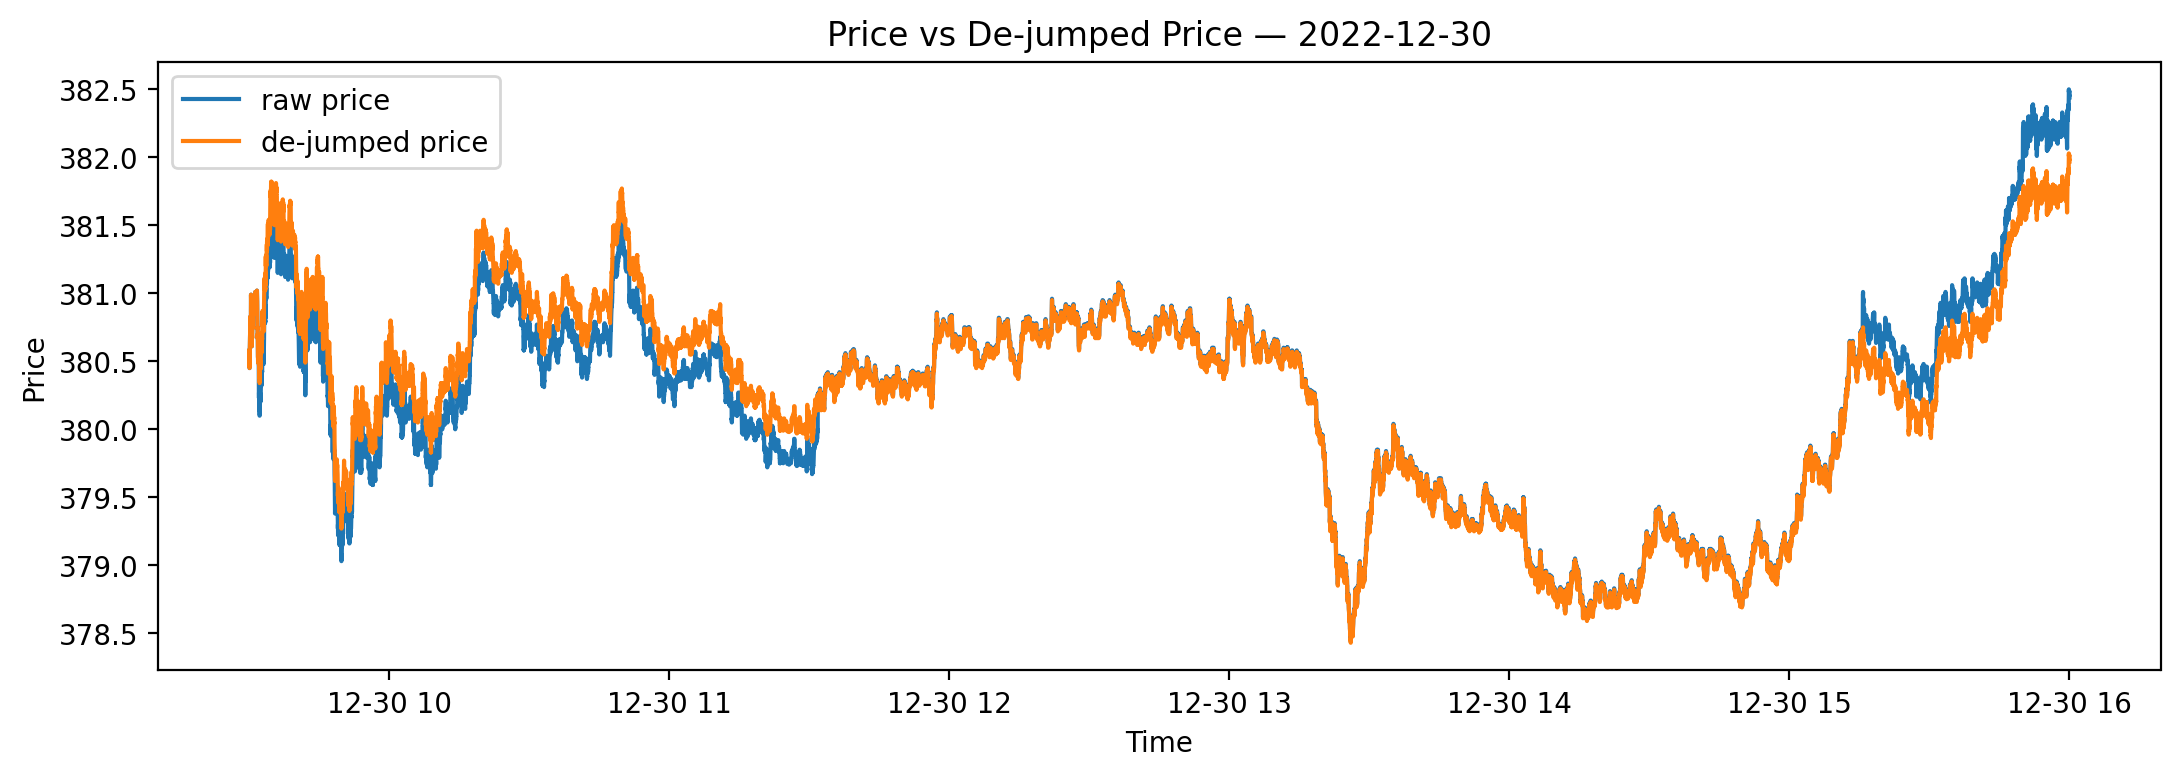

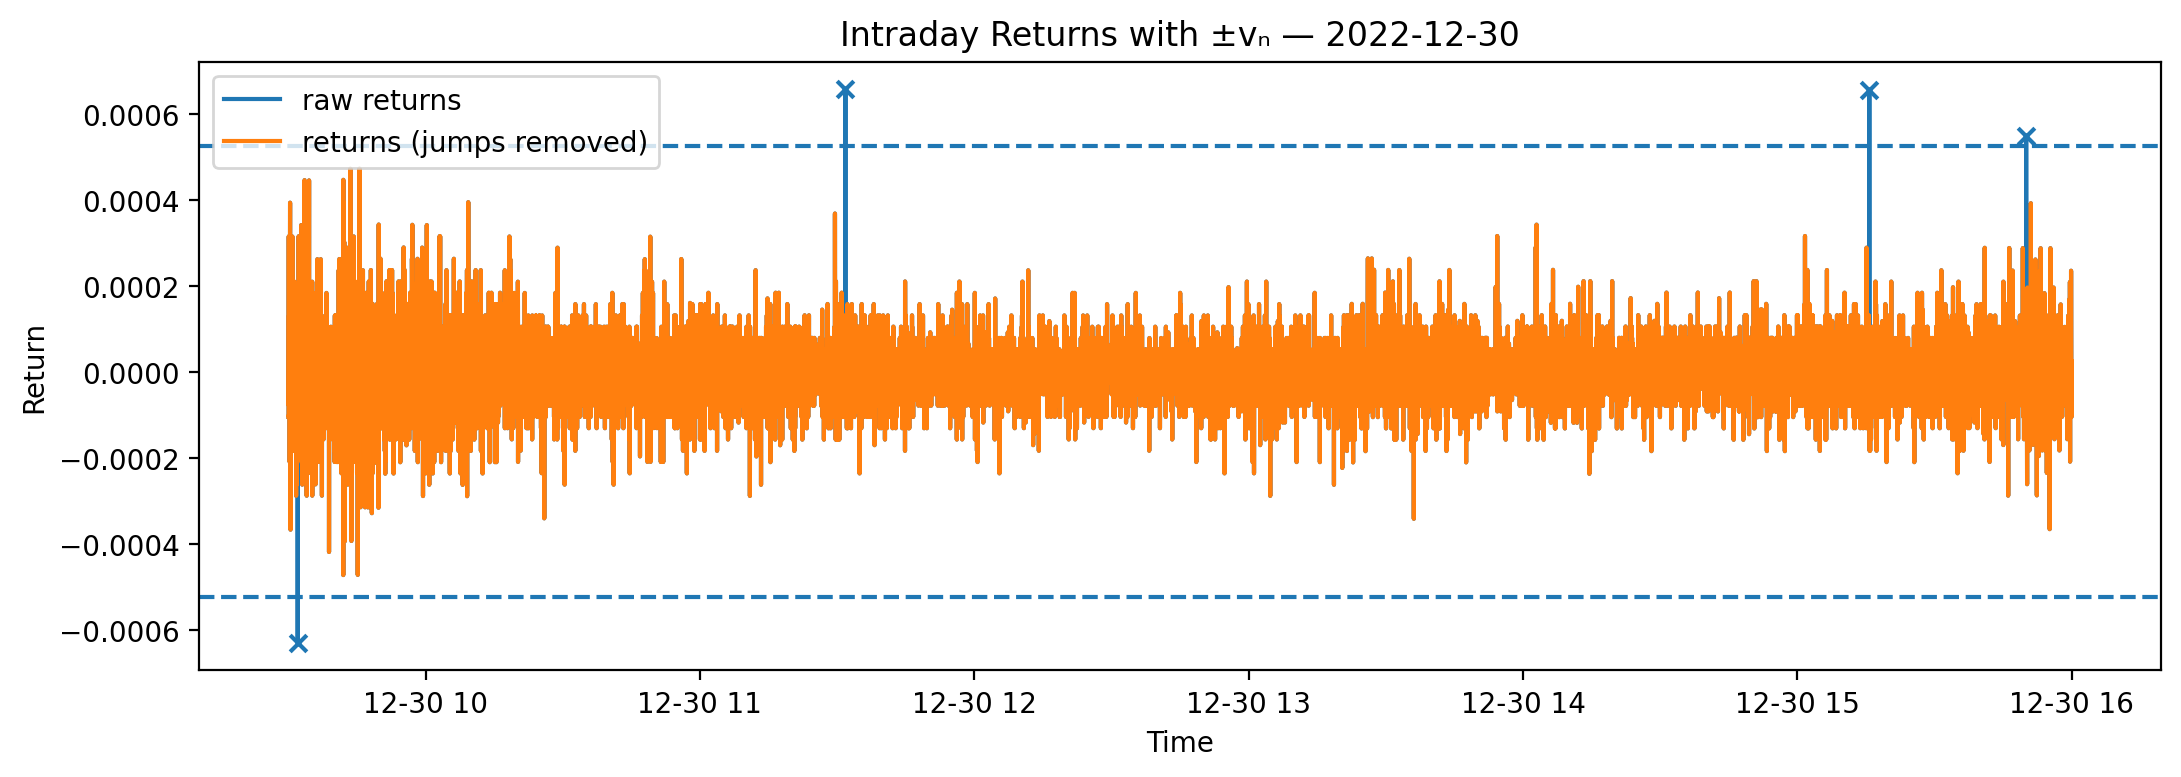

In [12]:
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date as Date

######################################################################################
################## REMOVE DATES ######################################################
######################################################################################
FOMC_announcement = [
    "2012-01-25","2012-03-13","2012-04-25","2012-06-20","2012-08-01","2012-09-13","2012-10-24","2012-12-12",
    "2013-01-30","2013-03-20","2013-05-01","2013-06-19","2013-07-31","2013-09-18","2013-10-30","2013-12-18",
    "2014-01-29","2014-03-19","2014-04-30","2014-06-18","2014-07-30","2014-09-17","2014-10-29","2014-12-17",
    "2015-01-28","2015-03-18","2015-04-29","2015-06-17","2015-07-29","2015-09-17","2015-10-28","2015-12-16",
    "2016-01-27","2016-03-16","2016-04-27","2016-06-15","2016-07-27","2016-09-21","2016-11-02","2016-12-14",
    "2017-02-01","2017-03-15","2017-05-03","2017-06-14","2017-07-26","2017-09-20","2017-11-01","2017-12-13",
    "2018-01-31","2018-03-21","2018-05-02","2018-06-13","2018-08-01","2018-09-26","2018-11-08","2018-12-19",
    "2019-01-30","2019-03-20","2019-05-01","2019-06-19","2019-07-31","2019-09-18","2019-10-30","2019-12-11",
    "2020-01-29","2020-04-29","2020-06-10","2020-07-29","2020-09-16","2020-11-05","2020-12-16",
    "2021-01-27","2021-03-17","2021-04-28","2021-06-16","2021-07-28","2021-09-22","2021-11-03","2021-12-15",
    "2022-01-26","2022-03-16","2022-05-04","2022-06-15","2022-07-27","2022-09-21","2022-11-02","2022-12-14",
]
trading_halt = [
    '2013-07-03','2013-11-29','2013-12-24',
    '2014-07-03','2014-10-30','2014-11-28','2014-12-24',
    '2015-11-27','2015-12-24',
    '2016-11-25',
    '2017-07-03','2017-11-24',
    '2018-07-03','2018-11-23','2018-12-24',
    "2019-07-03","2019-08-12","2019-11-29","2019-12-24",
    "2020-03-09","2020-03-12","2020-03-16","2020-03-18","2020-11-27","2020-12-24",
    "2021-05-05","2022-11-26","2022-11-25"
]
EXCLUDE_DATES = {Date.fromisoformat(s) for s in FOMC_announcement} | {Date.fromisoformat(s) for s in trading_halt}

####################################################################################
################## LOAD FILES ######################################################
####################################################################################
def load_daily_dir_to_polars(
    dir_path: str | Path = "daily_csv",
    *,
    dt_col: str = "DT",
    px_col: str = "Price",
) -> pl.DataFrame:
    """
    Reads all CSVs in dir_path with columns [DT, Price] -> ['timestamp','price'].
    Skips empty/iCloud placeholder files (size == 0). Uses scan_csv for speed.
    """
    dir_path = Path(dir_path)
    files = sorted(p for p in dir_path.glob("*.csv") if p.is_file() and p.stat().st_size > 0)
    if not files:
        raise FileNotFoundError(f"No non-empty CSV files in {dir_path.resolve()}")

    lfs = []
    for p in files:
        lf = (
            pl.scan_csv(p, has_header=True, infer_schema_length=0, ignore_errors=True)
            .select([
                pl.col(dt_col).alias("DT"),
                pl.col(px_col).cast(pl.Float64).alias("Price"),
            ])
            .with_columns([
                pl.col("DT").str.strptime(pl.Datetime, strict=False).alias("timestamp"),
                pl.col("Price").alias("price"),
            ])
            .select(["timestamp","price"])
        )
        lfs.append(lf)

    df = (
        pl.concat(lfs, how="vertical_relaxed")
        .drop_nulls(["timestamp","price"])
        .unique(subset=["timestamp"], keep="last")
        .sort("timestamp")
        .collect(streaming=True)
        .rechunk()
    )
    return df

#####################################################################################
################## JUMP FILTER ######################################################
#####################################################################################

def infer_eps_seconds(df: pl.DataFrame, ts_col: str = "timestamp") -> float:
    """Infer ε_n (seconds) from median within-day spacing."""
    return float(
        df.with_columns(pl.col(ts_col).dt.date().alias("date"))
          .group_by("date")
          .agg(pl.col(ts_col).diff().drop_nulls().alias("dts"))
          .explode("dts")
          .select(pl.col("dts").dt.total_seconds().alias("sec"))
          .select(pl.median("sec").alias("eps"))
          .item()
    )

def filter_jumps_paper_threshold(
    df: pl.DataFrame,
    *,
    ts_col: str = "timestamp",
    px_col: str = "price",
    gamma: float = 0.49,
    kappa: float = 8.0,
    eps_seconds: float | None = None,
    drop_excluded_days: bool = True,
):
    """
    Apply |Δy| <= v_n with v_n = kappa * ε_n^gamma (ignore microstructure noise).
    Returns (out_df, clean_df, v_n, eps_seconds).
    - out_df keeps all rows and sets jump returns to NULL in 'ret_nojump'
    - clean_df drops jump increments entirely
    """
    df0 = df
    if drop_excluded_days:
        df0 = (
            df0
            .with_columns(pl.col(ts_col).dt.date().alias("date"))
            .filter(~pl.col("date").is_in(list(EXCLUDE_DATES)))
            .drop("date")
        )

    if eps_seconds is None:
        eps_seconds = infer_eps_seconds(df0, ts_col)

    df1 = (
        df0
        .with_columns([
            pl.col(ts_col).dt.date().alias("date"),
            pl.col(px_col).log().alias("logp"),
        ])
        .with_columns([
            pl.when(pl.col("date") == pl.col("date").shift(1))
              .then(pl.col("logp") - pl.col("logp").shift(1))
              .otherwise(None)
              .alias("ret")
        ])
    )

    v_n = kappa * (eps_seconds ** gamma)

    out = (
        df1
        .with_columns([
            pl.col("ret").abs().alias("abs_ret"),
            pl.lit(v_n).alias("v_n"),
            (pl.col("ret").abs() > v_n).alias("is_jump"),
            pl.when(pl.col("ret").abs() > v_n).then(None).otherwise(pl.col("ret")).alias("ret_nojump"),
        ])
    )
    clean = out.filter(~pl.col("is_jump").fill_null(False))
    return out, clean, v_n, eps_seconds

####################################################################
################## SANITY CHECK ####################################
####################################################################

def sanity_checks(out_df: pl.DataFrame, v_n: float, eps: float):
    TOL = 1e-12
    base = out_df.filter(pl.col("ret").is_not_null())

    false_neg = base.filter(~pl.col("is_jump") & (pl.col("abs_ret") > pl.col("v_n") + TOL)).height
    false_pos = base.filter(pl.col("is_jump") & (pl.col("abs_ret") <= pl.col("v_n") - TOL)).height

    mismatch_keep = base.filter(
        (~pl.col("is_jump")) & ((pl.col("ret_nojump") - pl.col("ret")).abs() > TOL)
    ).height
    mismatch_drop = base.filter((pl.col("is_jump")) & pl.col("ret_nojump").is_not_null()).height

    max_kept_minus_vn = float(
        base.filter(~pl.col("is_jump"))
            .select((pl.col("abs_ret").max() - pl.col("v_n").first()).alias("diff"))
            .item()
    )

    present_excluded_days = (
        out_df
        .select(pl.col("timestamp").dt.date().alias("date"))
        .unique()
        .filter(pl.col("date").is_in(list(EXCLUDE_DATES)))
        .height
    )

    print("=== Sanity: logical constraints ===")
    print(f"False negatives (kept but |ret|>v_n): {false_neg}")
    print(f"False positives (flagged jump but |ret|<=v_n): {false_pos}")
    print(f"Mismatch kept (ret_nojump ≠ ret when not a jump): {mismatch_keep}")
    print(f"Mismatch dropped (ret_nojump not NULL on a jump): {mismatch_drop}")
    print(f"Max(|ret| among kept) - v_n: {max_kept_minus_vn:.3e}")
    print(f"Excluded days still present: {present_excluded_days}")

    assert false_neg == 0
    assert false_pos == 0
    assert mismatch_keep == 0
    assert mismatch_drop == 0
    assert max_kept_minus_vn <= TOL
    assert present_excluded_days == 0

    dropped_share = float(
        base.select(pl.col("is_jump").fill_null(False).mean().alias("share_dropped")).item()
    )
    print("\n=== Diagnostics ===")
    print(f"Share of increments dropped as jumps: {dropped_share:.4%}")

    q = (
        base.select([
            pl.col("ret").abs().quantile(0.999).alias("q999_raw"),
            pl.col("ret_nojump").abs().quantile(0.999).alias("q999_trunc"),
            pl.col("abs_ret").max().alias("max_abs_raw"),
        ])
        .to_dicts()[0]
    )
    print(f"abs(ret) 99.9% quantile: raw={q['q999_raw']:.3e}  |  truncated={q['q999_trunc']:.3e}")
    print(f"abs(ret) max (raw): {q['max_abs_raw']:.3e}   |  v_n={v_n:.3e}")

    rv_daily = (
        out_df
        .select([
            pl.col("timestamp").dt.date().alias("date"),
            (pl.col("ret")**2).alias("rv_raw"),
            (pl.col("ret_nojump")**2).alias("rv_trunc")
        ])
        .group_by("date")
        .agg([
            pl.sum("rv_raw").alias("RV_raw"),
            pl.sum("rv_trunc").alias("RV_trunc"),
        ])
        .with_columns((pl.col("RV_trunc") / pl.col("RV_raw")).alias("ratio"))
        .sort("date")
    )

    rv_stats = rv_daily.select([
        pl.col("ratio").mean().alias("mean_ratio"),
        pl.col("ratio").quantile(0.1).alias("p10"),
        pl.col("ratio").quantile(0.5).alias("p50"),
        pl.col("ratio").quantile(0.9).alias("p90"),
    ]).to_dicts()[0]

    print("\n=== Realized-variance check (RV_trunc / RV_raw) ===")
    print(f"mean={rv_stats['mean_ratio']:.3f} | p10={rv_stats['p10']:.3f} | "
          f"p50={rv_stats['p50']:.3f} | p90={rv_stats['p90']:.3f}")

    jump_summary = (
        out_df
        .select([
            pl.col("timestamp").dt.date().alias("date"),
            pl.col("is_jump")
        ])
        .group_by("date")
        .agg([
            pl.len().alias("n_obs"),
            pl.col("is_jump").sum().fill_null(0).cast(pl.Int64).alias("n_jumps")
        ])
        .with_columns((pl.col("n_jumps") / pl.col("n_obs")).alias("jump_rate"))
        .sort("jump_rate", descending=True)
        .head(10)
    )
    print("\nTop-10 days by jump rate:")
    print(jump_summary)

    impact_summary = (
        rv_daily
        .with_columns((1 - pl.col("ratio")).alias("rv_reduction"))
        .sort("rv_reduction", descending=True)
        .head(10)
    )
    print("\nTop-10 days by RV reduction:")
    print(impact_summary)

###########################################################################################
################## KAPPA CALIBRATION ######################################################
###########################################################################################

def calibrate_kappa(out_df: pl.DataFrame, eps_seconds: float, gamma: float = 0.49, alpha: float = 0.001) -> float:
    """
    Calibrate kappa via v_n ≈ q_{1-α}(|Δy|):  kappa = q / ε_n^γ.
    """
    base = out_df.filter(pl.col("ret").is_not_null())
    q_tail = float(base.select(pl.col("ret").abs().quantile(1 - alpha).alias("q")).item())
    kappa_new = q_tail / (eps_seconds ** gamma)
    return kappa_new

def reconstruct_dejumped_prices(out_df: pl.DataFrame) -> pl.DataFrame:
    """
    For each day: price_nojump = exp( logp0 + cumsum(ret_nojump with NULL->0) )
    """
    return (
        out_df
        .with_columns([
            pl.col("timestamp").dt.date().alias("date"),
            pl.col("ret_nojump").fill_null(0.0).alias("ret_nj0"),
        ])
        .with_columns([
            pl.col("ret_nj0").cum_sum().over("date").alias("cs_ret_nj0"),
            pl.first("logp").over("date").alias("logp0"),
        ])
        .with_columns((pl.col("logp0") + pl.col("cs_ret_nj0")).exp().alias("price_nojump"))
        .select(["timestamp","date","price","price_nojump","ret","ret_nojump","is_jump","v_n"])
        .sort("timestamp")
    )

def plot_day(out_df: pl.DataFrame, DAY: str | None = None):
    pdf = reconstruct_dejumped_prices(out_df)
    last_day = pdf.select(pl.max("date")).item()
    day = Date.fromisoformat(DAY) if DAY else last_day

    day_view = (
        pdf.filter(pl.col("date") == pl.lit(day))
           .select(["timestamp","price","price_nojump","ret","ret_nojump","is_jump","v_n"])
           .to_pandas()
    )

    
    plt.figure(figsize=(11,4))
    plt.plot(day_view["timestamp"], day_view["price"], label="raw price")
    plt.plot(day_view["timestamp"], day_view["price_nojump"], label="de-jumped price")
    plt.title(f"Price vs De-jumped Price — {day}")
    plt.xlabel("Time"); plt.ylabel("Price"); plt.legend(); plt.tight_layout(); plt.show()

    
    plt.figure(figsize=(11,4))
    plt.plot(day_view["timestamp"], day_view["ret"], label="raw returns")
    plt.plot(day_view["timestamp"], day_view["ret_nojump"], label="returns (jumps removed)")
    if len(day_view):
        vn = float(day_view["v_n"].iloc[0])
        plt.axhline(vn, linestyle="--"); plt.axhline(-vn, linestyle="--")
    if "is_jump" in day_view.columns:
        m = day_view["is_jump"] == True
        if m.any():
            plt.scatter(day_view.loc[m,"timestamp"], day_view.loc[m,"ret"], marker="x")
    plt.title(f"Intraday Returns with ±vₙ — {day}")
    plt.xlabel("Time"); plt.ylabel("Return"); plt.legend(); plt.tight_layout(); plt.show()

def plot_overview(out_df: pl.DataFrame, df_price: pl.DataFrame):

    p_all = df_price.select(["timestamp","price"]).to_pandas()
    plt.figure(figsize=(11,4)); plt.plot(p_all["timestamp"], p_all["price"])
    plt.title("Price over time"); plt.xlabel("Time"); plt.ylabel("Price"); plt.tight_layout(); plt.show()

    jump_daily = (
        out_df
        .select([
            pl.col("timestamp").dt.date().alias("date"),
            pl.col("is_jump")
        ])
        .group_by("date")
        .agg([
            pl.len().alias("n_obs"),
            pl.col("is_jump").sum().fill_null(0).cast(pl.Int64).alias("n_jumps")
        ])
        .sort("date")
        .to_pandas()
    )
    plt.figure(figsize=(11,4))
    plt.bar(jump_daily["date"].astype(str), jump_daily["n_jumps"])
    plt.title("Number of jumps per day"); plt.xlabel("Date"); plt.ylabel("# jumps")
    plt.xticks(rotation=90); plt.tight_layout(); plt.show()


    rv_daily = (
        out_df
        .select([
            pl.col("timestamp").dt.date().alias("date"),
            (pl.col("ret")**2).alias("rv_raw"),
            (pl.col("ret_nojump")**2).alias("rv_trunc")
        ])
        .group_by("date")
        .agg([
            pl.sum("rv_raw").alias("RV_raw"),
            pl.sum("rv_trunc").alias("RV_trunc"),
        ])
        .sort("date")
        .to_pandas()
    )
    plt.figure(figsize=(11,4))
    plt.plot(rv_daily["date"].astype(str), rv_daily["RV_raw"], label="RV raw")
    plt.plot(rv_daily["date"].astype(str), rv_daily["RV_trunc"], label="RV truncated")
    plt.title("Daily realized variance: raw vs jump-truncated")
    plt.xlabel("Date"); plt.ylabel("Realized variance")
    plt.xticks(rotation=90); plt.legend(); plt.tight_layout(); plt.show()


df = load_daily_dir_to_polars("daily_csv")
print(df.head()); print(df.schema)

gamma = 0.49
out_df0, clean_df0, v_n0, eps = filter_jumps_paper_threshold(
    df, gamma=gamma, kappa=1.0, eps_seconds=None, drop_excluded_days=True
)
print(f"ε_n (seconds) inferred = {eps:.6g} | (temporary) v_n = {v_n0:.6g}")

alpha = 0.001  # 0.1% tail
kappa_hat = calibrate_kappa(out_df0, eps_seconds=eps, gamma=gamma, alpha=alpha)
print(f"Calibrated kappa @ alpha={alpha:.4f} -> kappa = {kappa_hat:.6g}")

out_df, clean_df, v_n, eps2 = filter_jumps_paper_threshold(
    df, gamma=gamma, kappa=kappa_hat, eps_seconds=eps, drop_excluded_days=True
)
print(f"Final v_n = {v_n:.6g} (using calibrated kappa)")


sanity_checks(out_df, v_n=v_n, eps=eps2)
plot_overview(out_df, df_price=df)
plot_day(out_df)            




$$
Z_t^{n,j}=
\begin{cases}
\bigl(k_n^{(j)}\delta_n\bigr)^{\frac12-2H}
\Bigl(\widehat V_{t}^{\,n,\ell_j,k_n^{(j)}}
      - \bigl(k_n^{(j)}\delta_n\bigr)^{2H-1} V_t^{\ell_j}\Bigr),
& \text{if }\ell_j\ge 2,\\[6pt]
\bigl(k_n^{(j)}\delta_n\bigr)^{\frac12-2H}
\Bigl(\widehat V_{t}^{\,n,0,k_n^{(j)}}
      + 2\,\widehat V_{t}^{\,n,1,k_n^{(j)}}
      - \bigl(k_n^{(j)}\delta_n\bigr)^{2H-1}\bigl(V_t^{0}+2V_t^{1}\bigr)\Bigr),
& \text{if }\ell_j=1.
\end{cases}
$$


In [13]:
from typing import Sequence, Tuple, Dict, List
import numpy as np
from dataclasses import dataclass

def infer_eps_dimless(df: pl.DataFrame) -> Tuple[float, float]:
    """
    Empirical ε_n as '1 / median(#returns per day)' so k_n ε_n is dimensionless.
    Works on out_df that already contains 'ret_nojump'.
    """
    tmp = (
        df.with_columns(pl.col("timestamp").dt.date().alias("date"))
          .with_columns(pl.col("ret_nojump").is_not_null().cast(pl.Int32).alias("has_ret"))
          .group_by("date").agg(pl.col("has_ret").sum().alias("n_increments"))
          .filter(pl.col("n_increments") > 0)
    )
    n_bar = float(tmp.select(pl.median("n_increments")).item())
    eps_n = 1.0 / n_bar
    return eps_n, n_bar  

def choose_k_list(eps_n: float, kappas: Sequence[float]) -> List[int]:
    """
    k_n ≈ κ * ε_n^{-1/2} * log(ε_n^{-1}). See the paper's choice for windows. :contentReference[oaicite:4]{index=4}
    """
    s = (eps_n**-0.5) * np.log(1.0/eps_n)
    ks = [max(2, int(round(kappa * s))) for kappa in kappas]
    return ks

# φ_ρ(H) from eq. (6) (5-point stencil); deterministic in H.
def phi_rho(H: float, rho: int) -> float:
    p = 2.0*H + 2.0
    f = lambda x: abs(float(x))**p
    num = (f(rho+2) - 4.0*f(rho+1) + 6.0*f(rho) - 4.0*f(rho-1) + f(rho-2))
    den = 2.0*(2.0*H+1.0)*(2.0*H+2.0)
    return num/den

# For the ρ=1 coordinate, the CLT/gmm uses a combination.
def phi_combo(H: float, rho: int) -> float:
    if rho == 1:
        return phi_rho(H, 0) + 2.0*phi_rho(H, 1)
    else:
        return phi_rho(H, rho)

##########################################################################################
################## \tilde V_{n,ρ,k}(t) ######################
##########################################################################################

def compute_pV_components(
    out_df: pl.DataFrame,
    eps_n: float,
    ks: Sequence[int],
    rhos: Sequence[int],
    ret_col: str = "ret_nojump",
) -> Dict[Tuple[int,int], float]:
    """
    Compute \tilde V_{n,ρ,k}(t) = (1/k) * sum_i (Δ^k c_i) (Δ^k c_{i+ρk}),
    with c_i = (1/(k ε_n)) ∑_{j=i}^{i+k-1} (ret_j^2). (Jump-truncated returns.)
    No volatility-jump truncation (paper shows it can be removed). :contentReference[oaicite:7]{index=7}
    Returns a dict keyed by (k, ρ).
    """
    df = (out_df
          .select(["timestamp", ret_col])
          .with_columns([
              pl.col("timestamp").dt.date().alias("date"),
              pl.coalesce([pl.col(ret_col), pl.lit(0.0)]).alias("r")  
          ])
          .sort("timestamp")
    )

    results: Dict[Tuple[int,int], float] = {}

    for k in ks:
        c_col = f"c_k{k}"
        d_col = f"dC_k{k}"
        df_k = df.with_columns([
            # rolling sum of r^2 within day; scale to spot variance estimate
            ((pl.col("r")**2).rolling_sum(window_size=k, min_periods=k).over("date") / (k*eps_n)).alias(c_col),
        ]).with_columns([
            # forward difference Δ^k c_i = c_{i+k} - c_i, within day
            (pl.col(c_col).shift(-k).over("date") - pl.col(c_col).over("date")).alias(d_col)
        ])

        for rho in rhos:
            tri_col = f"tri_r{rho}_k{k}"
            df_tri = df_k.with_columns([
                # product (Δ^k c_i) (Δ^k c_{i+ρk}), all within the same day via 'over'
                (pl.col(d_col).over("date") * pl.col(d_col).shift(rho*k).over("date")).alias(tri_col)
            ])
            # (1/k) * sum over valid i across the whole sample
            val = float(df_tri.select(pl.col(tri_col).drop_nulls().sum()).item()) / k
            results[(k, rho)] = val

    return results

################## Assemble rV_n(t) entries and estimate (H, R_t) by 1D optimization ##################

@dataclass
class GMMSetup:
    kappas: List[float]
    rhos:   List[int]   

@dataclass
class GMMResult:
    H_hat: float
    R_hat: float
    ks: List[int]
    eps_n: float
    kn_epsn: List[float]           # k_n ε_n for each coordinate
    rV_vec: np.ndarray             # data vector
    phi_vec_hat: np.ndarray        # φ(H_hat) vector
    Z_vec: np.ndarray              # Z_t^{n,j} at the optimum

def build_rV_vector(pV: Dict[Tuple[int,int], float], ks: List[int], rhos: List[int]) -> np.ndarray:
    vals = []
    for k, rho in zip(ks, rhos):
        if rho == 1:
            # rV^{(j)} = \tilde V_{n,0,k} + 2 \tilde V_{n,1,k}. 
            vals.append(pV[(k,0)] + 2.0 * pV[(k,1)])
        else:
            vals.append(pV[(k,rho)])
    return np.asarray(vals, dtype=float)

def phi_vector(H: float, rhos: List[int]) -> np.ndarray:
    return np.asarray([phi_combo(H, rho) for rho in rhos], dtype=float)

def closed_form_R_hat(W: np.ndarray, rV: np.ndarray, phiH: np.ndarray) -> float:
    num = phiH.T @ W @ rV
    den = phiH.T @ W @ phiH
    return float(num/den)

def minimize_over_H(
    rV: np.ndarray,
    rhos: List[int],
    W: np.ndarray | None = None,
    H_grid: np.ndarray | None = None,
) -> Tuple[float, float, np.ndarray]:
    """
    Minimize || W^{1/2}( rV - φ(H) R(H) ) ||^2 over H in (0, 1/2).
    R(H) is in closed form. Weight W defaults to Identity.
    Coarse-to-fine 1-D search (no SciPy needed).
    """
    m = len(rV)
    W = np.eye(m) if W is None else W
    if H_grid is None:
        H_grid = np.linspace(0.05, 0.49, 451)  # fine grid

    best = (np.inf, None, None)  # (obj, H, R)
    for H in H_grid:
        phiH = phi_vector(H, rhos)
        R = closed_form_R_hat(W, rV, phiH)
        resid = rV - phiH * R
        obj = resid.T @ W @ resid
        if obj < best[0]:
            best = (obj, H, R)

    H_hat, R_hat = float(best[1]), float(best[2])
    return H_hat, R_hat, phi_vector(H_hat, rhos)

def compute_Z_vec(
    rV: np.ndarray, ks: List[int], eps_n: float, rhos: List[int], H_hat: float, R_hat: float
) -> np.ndarray:
    """
    Z^{n,j}_t after plugging (H_hat, R_hat).
    Uses (k ε)^{1/2 - 2H} [ rV_j - φ_j(H) R_hat ]. See eq. (9). :contentReference[oaicite:9]{index=9}
    """
    phiH = phi_vector(H_hat, rhos)
    scales = np.asarray([(k*eps_n)**(0.5 - 2.0*H_hat) for k in ks])
    return scales * (rV - phiH * R_hat)

def estimate_H_R_and_Z(
    out_df: pl.DataFrame,
    setup: GMMSetup,
    ret_col: str = "ret_nojump",
    W: np.ndarray | None = None,
) -> GMMResult:
    # ε_n and k list
    eps_n, _ = infer_eps_dimless(out_df)
    ks = choose_k_list(eps_n, setup.kappas)

    # need pV_{ρ,k} for all ρ we might combine
    needed_rhos = sorted(set([0 if r==1 else r for r in setup.rhos] + [1 if 1 in setup.rhos else -1]))
    if -1 in needed_rhos: needed_rhos.remove(-1)
    pV = compute_pV_components(out_df, eps_n, ks, needed_rhos, ret_col=ret_col)

    # data vector
    rV_vec = build_rV_vector(pV, ks, setup.rhos)

    # estimate
    H_hat, R_hat, phi_hat = minimize_over_H(rV_vec, setup.rhos, W=W)

    # Z and k_n ε_n
    Z_vec = compute_Z_vec(rV_vec, ks, eps_n, setup.rhos, H_hat, R_hat)
    kn_epsn = [k*eps_n for k in ks]

    return GMMResult(
        H_hat=H_hat, R_hat=R_hat, ks=ks, eps_n=eps_n,
        kn_epsn=kn_epsn, rV_vec=rV_vec, phi_vec_hat=phi_hat, Z_vec=Z_vec
    )


################### example ######################################################
setup = GMMSetup(
    kappas=[0.9, 1.2, 1.6, 2.0],   
    rhos   =[0,   1,   2,   5]     
)

res = estimate_H_R_and_Z(out_df, setup, ret_col="ret_nojump")

print("\n=== Data-driven window sizes ===")
for j,(k,keps) in enumerate(zip(res.ks, res.kn_epsn), start=1):
    print(f"j={j}: k_n={k:5d},  k_n*ε_n={keps:.5f}")

print(f"\nEstimated H: {res.H_hat:.4f}")
print(f"Estimated R_t = ∫_0^t |η|^2 ds: {res.R_hat:.6g}")

print("\nVector V_n(t):\n", res.rV_vec)
print("\nφ(H_hat):\n", res.phi_vec_hat)
print("\nZ_t^{n,j} at optimum (should look ≈ mean-zero across coords under CLT scaling):\n", res.Z_vec)


/var/folders/4w/x8plpw_x0pb6wcfdl87b6lxc0000gp/T/ipykernel_6541/11515031.py:76: DeprecationWarning: the argument `min_periods` for `Expr.rolling_sum` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  ((pl.col("r")**2).rolling_sum(window_size=k, min_periods=k).over("date") / (k*eps_n)).alias(c_col),



=== Data-driven window sizes ===
j=1: k_n= 1385,  k_n*ε_n=0.05920
j=2: k_n= 1847,  k_n*ε_n=0.07894
j=3: k_n= 2462,  k_n*ε_n=0.10523
j=4: k_n= 3078,  k_n*ε_n=0.13156

Estimated H: 0.1136
Estimated R_t = ∫_0^t |η|^2 ds: 8.77583e-05

Vector V_n(t):
 [ 2.23461898e-05  1.61830920e-05  4.75167742e-08 -4.35607446e-07]

φ(H_hat):
 [ 0.24953418  0.18466311 -0.03470649 -0.00523522]

Z_t^{n,j} at optimum (should look ≈ mean-zero across coords under CLT scaling):
 [ 2.06894502e-07 -1.13214297e-08  1.67329206e-06  1.36989524e-08]


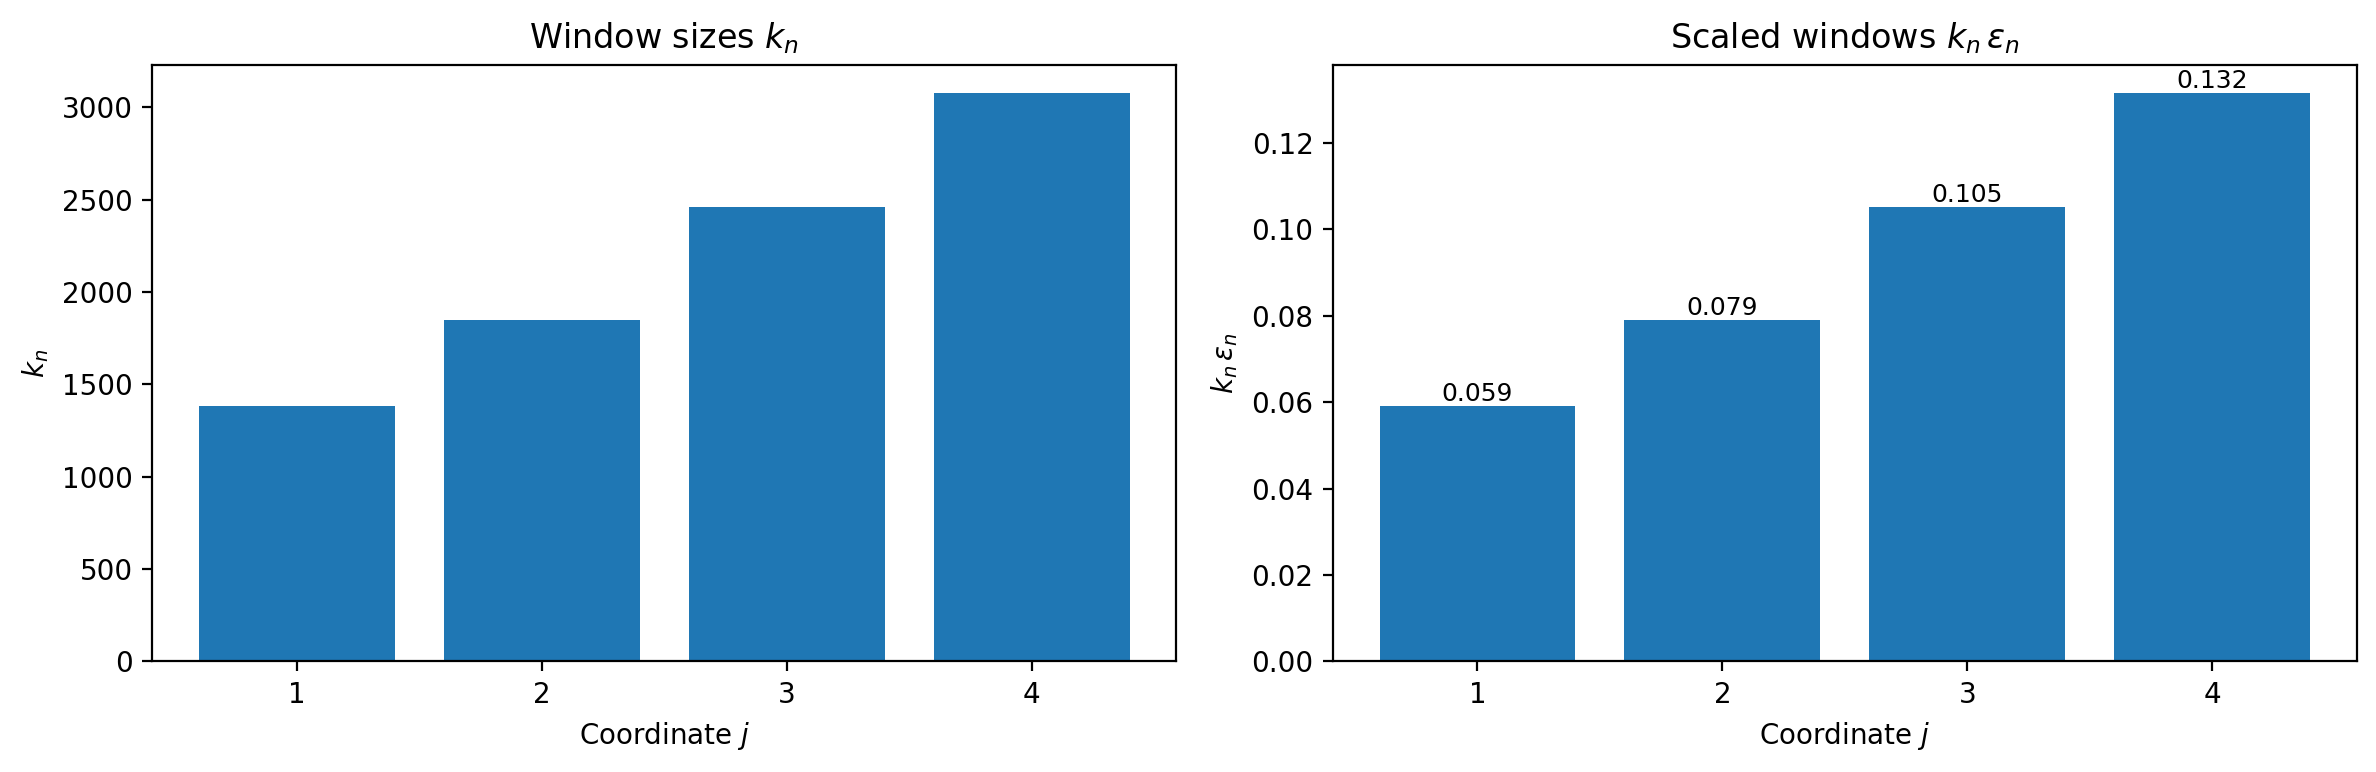

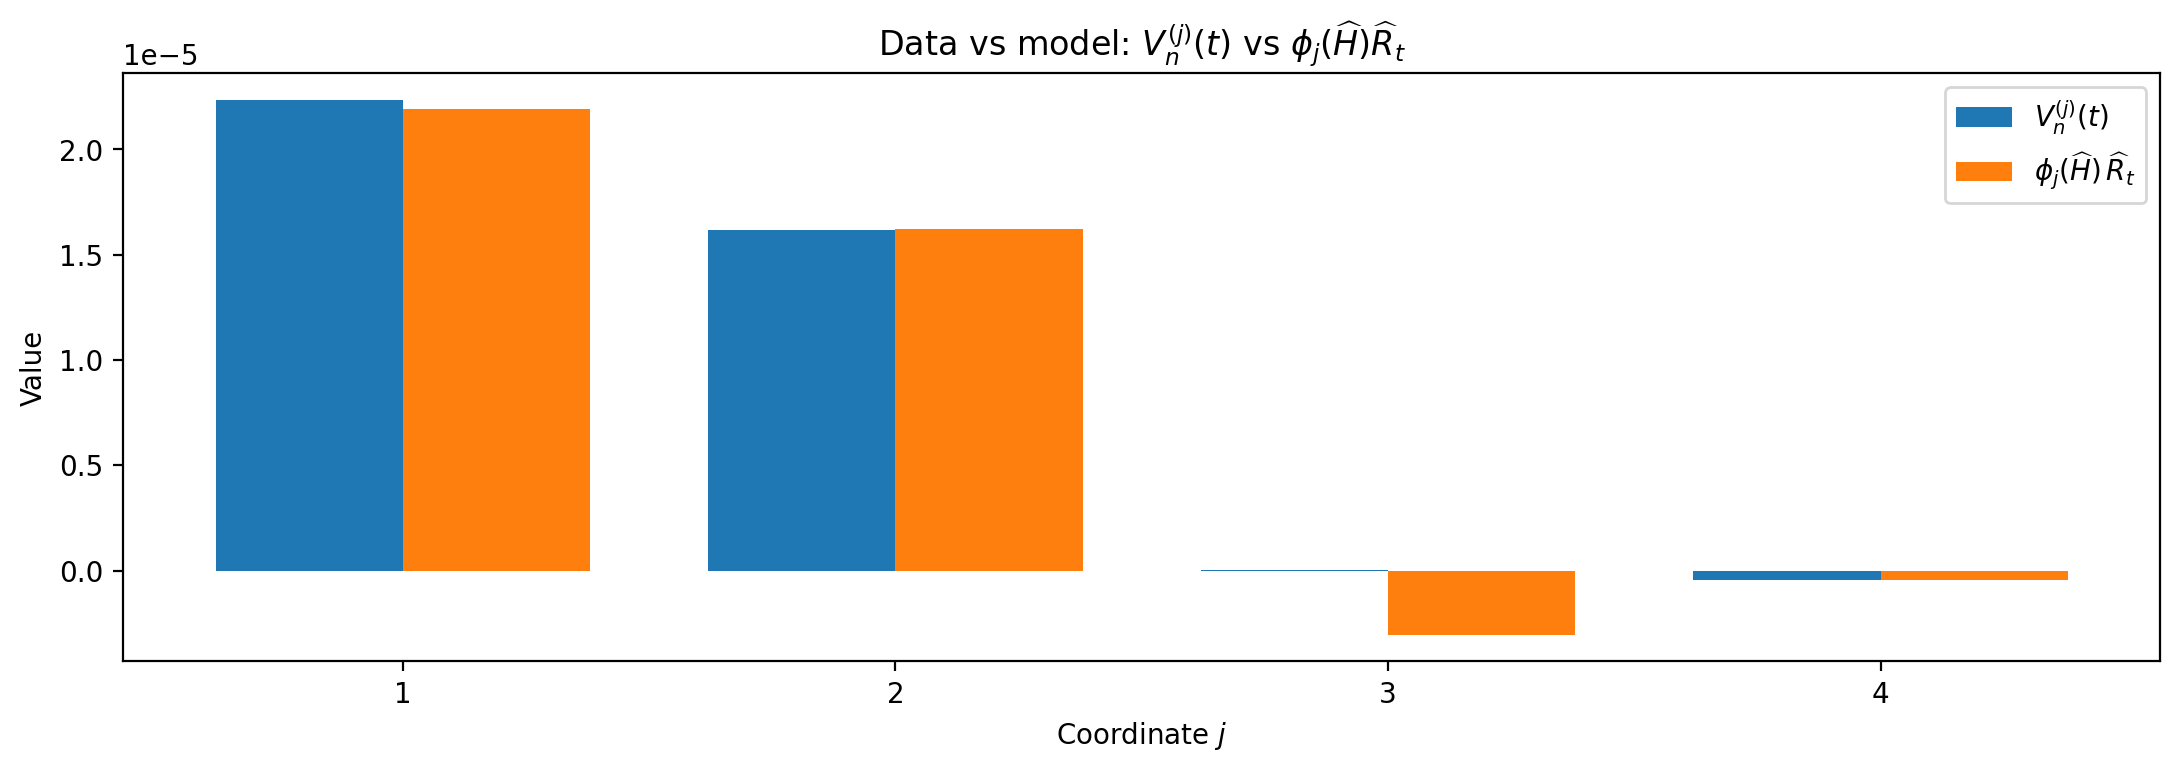

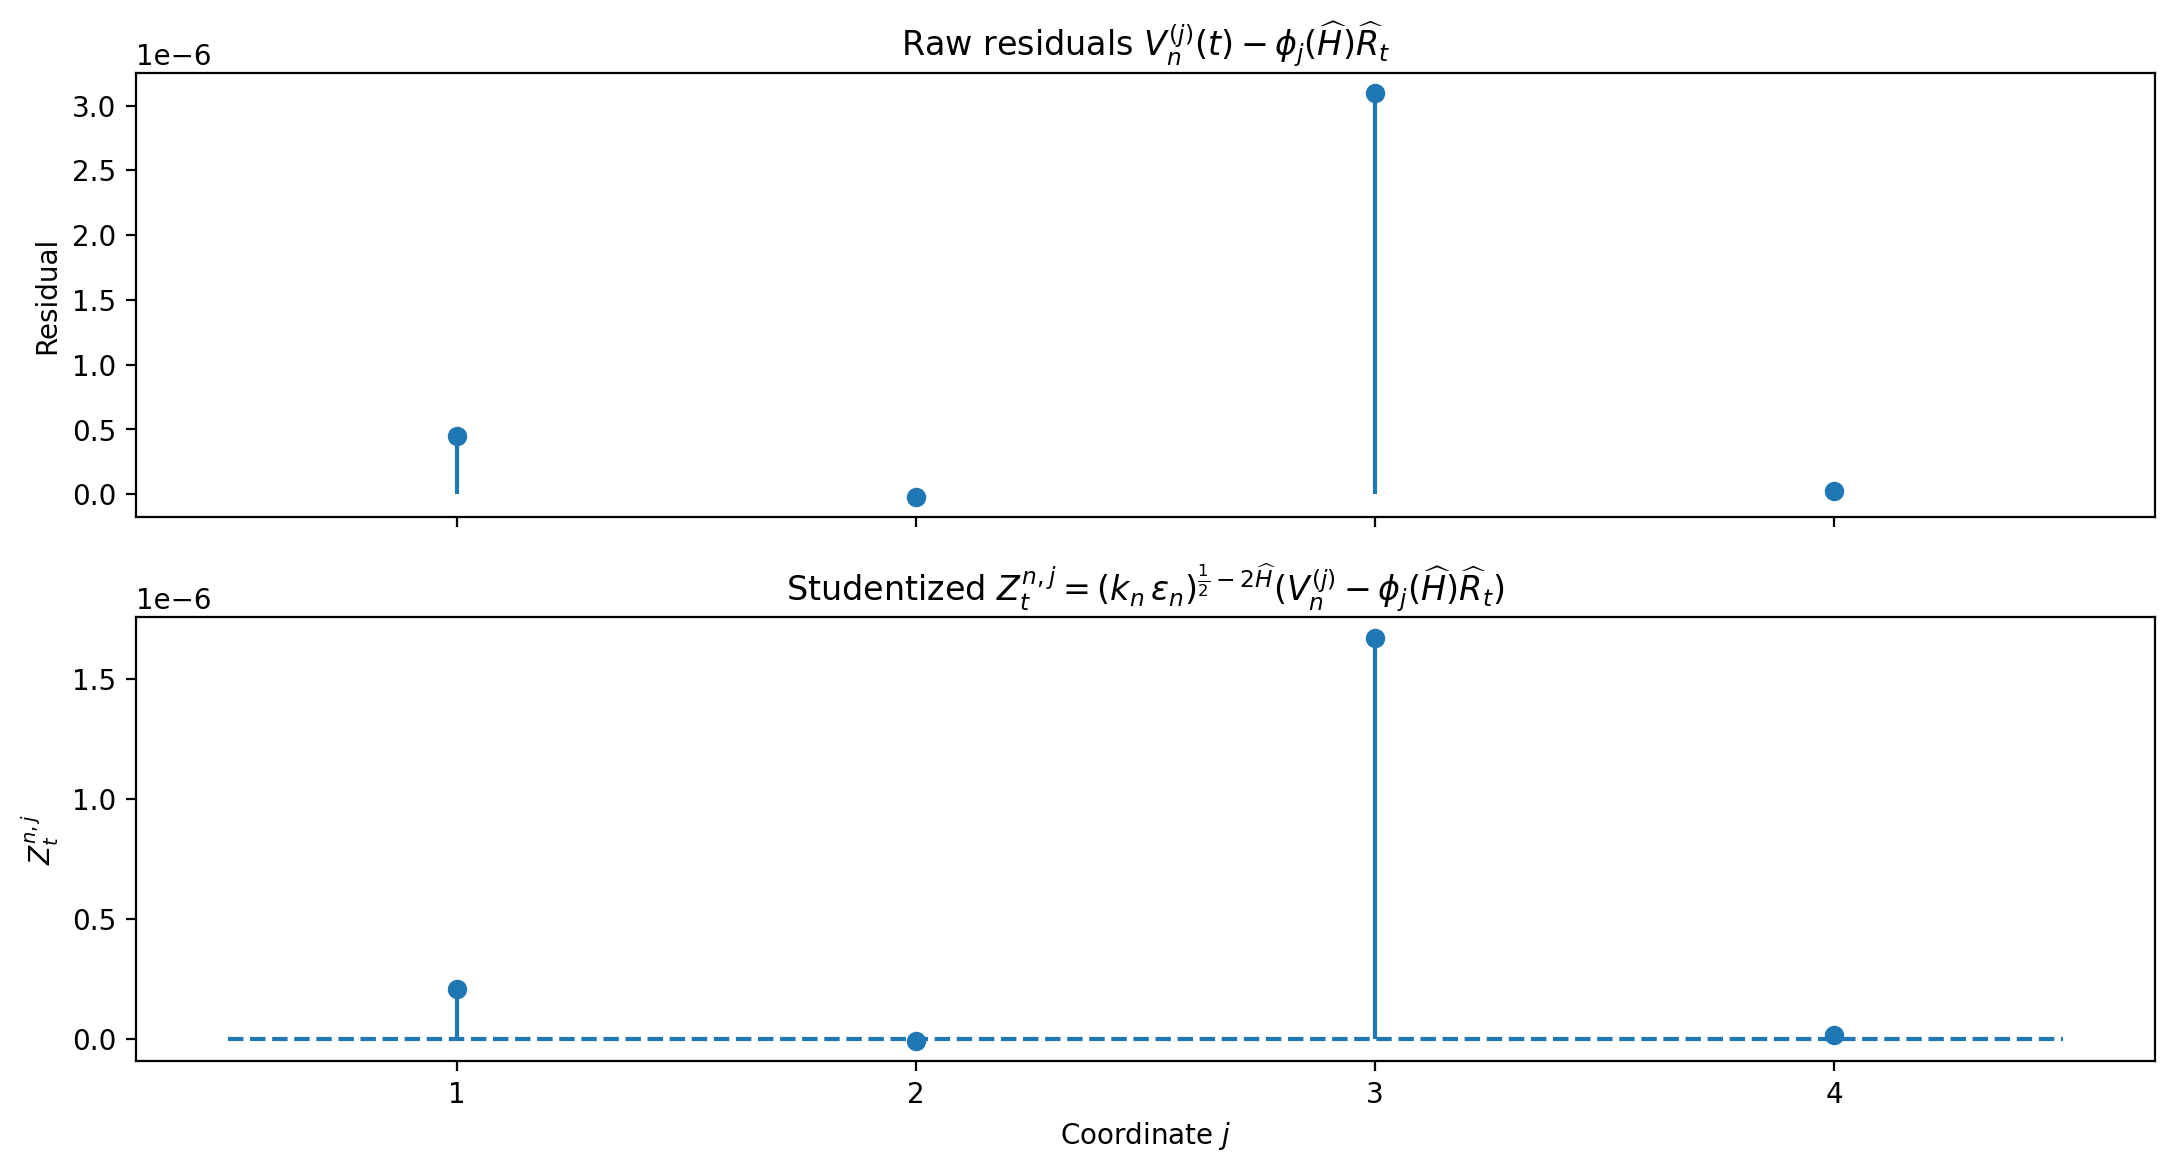

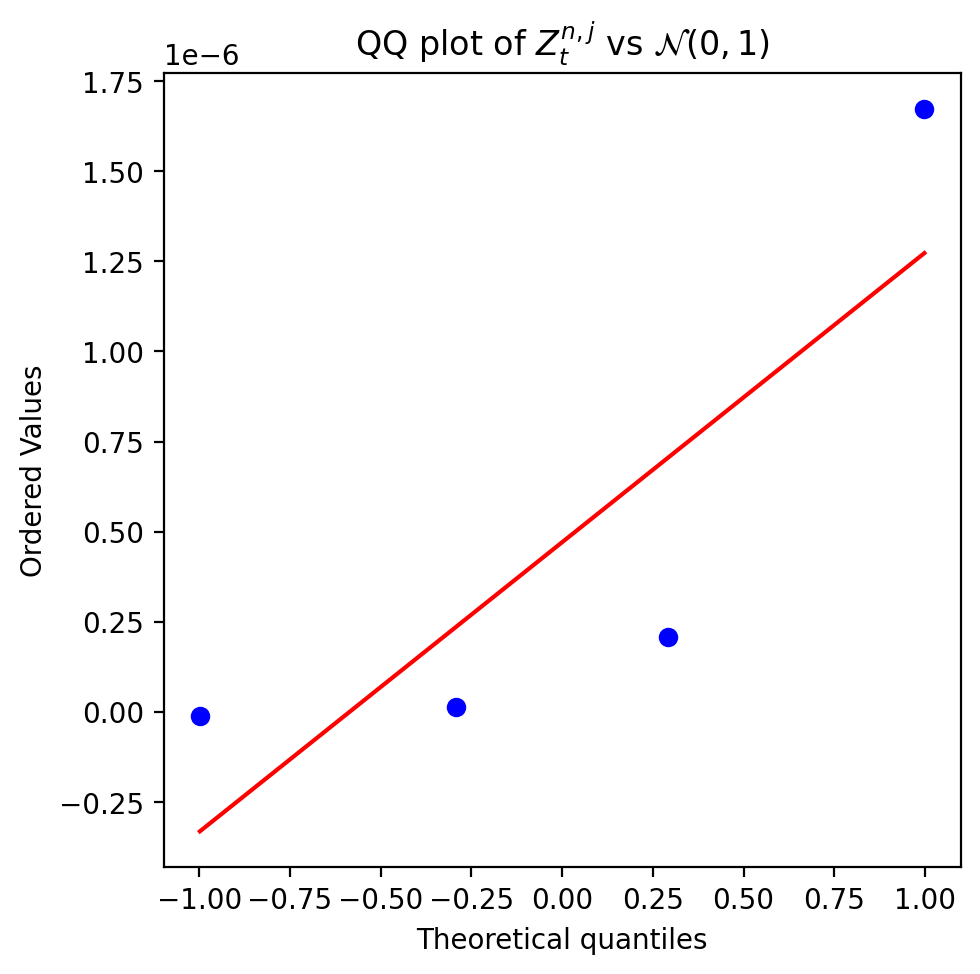

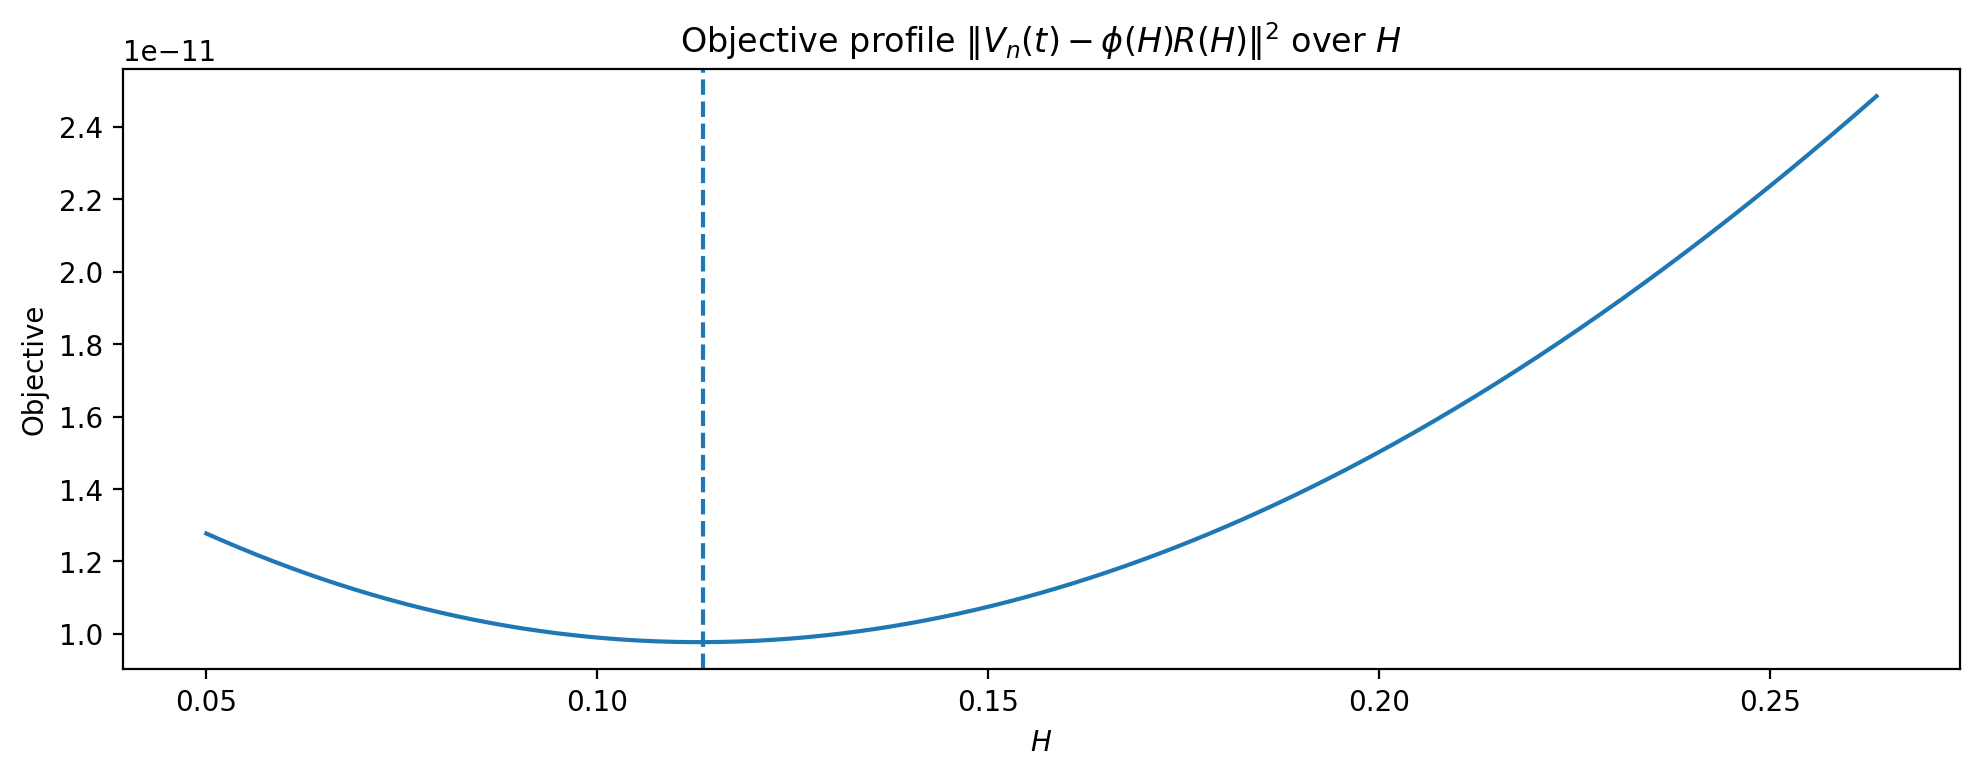

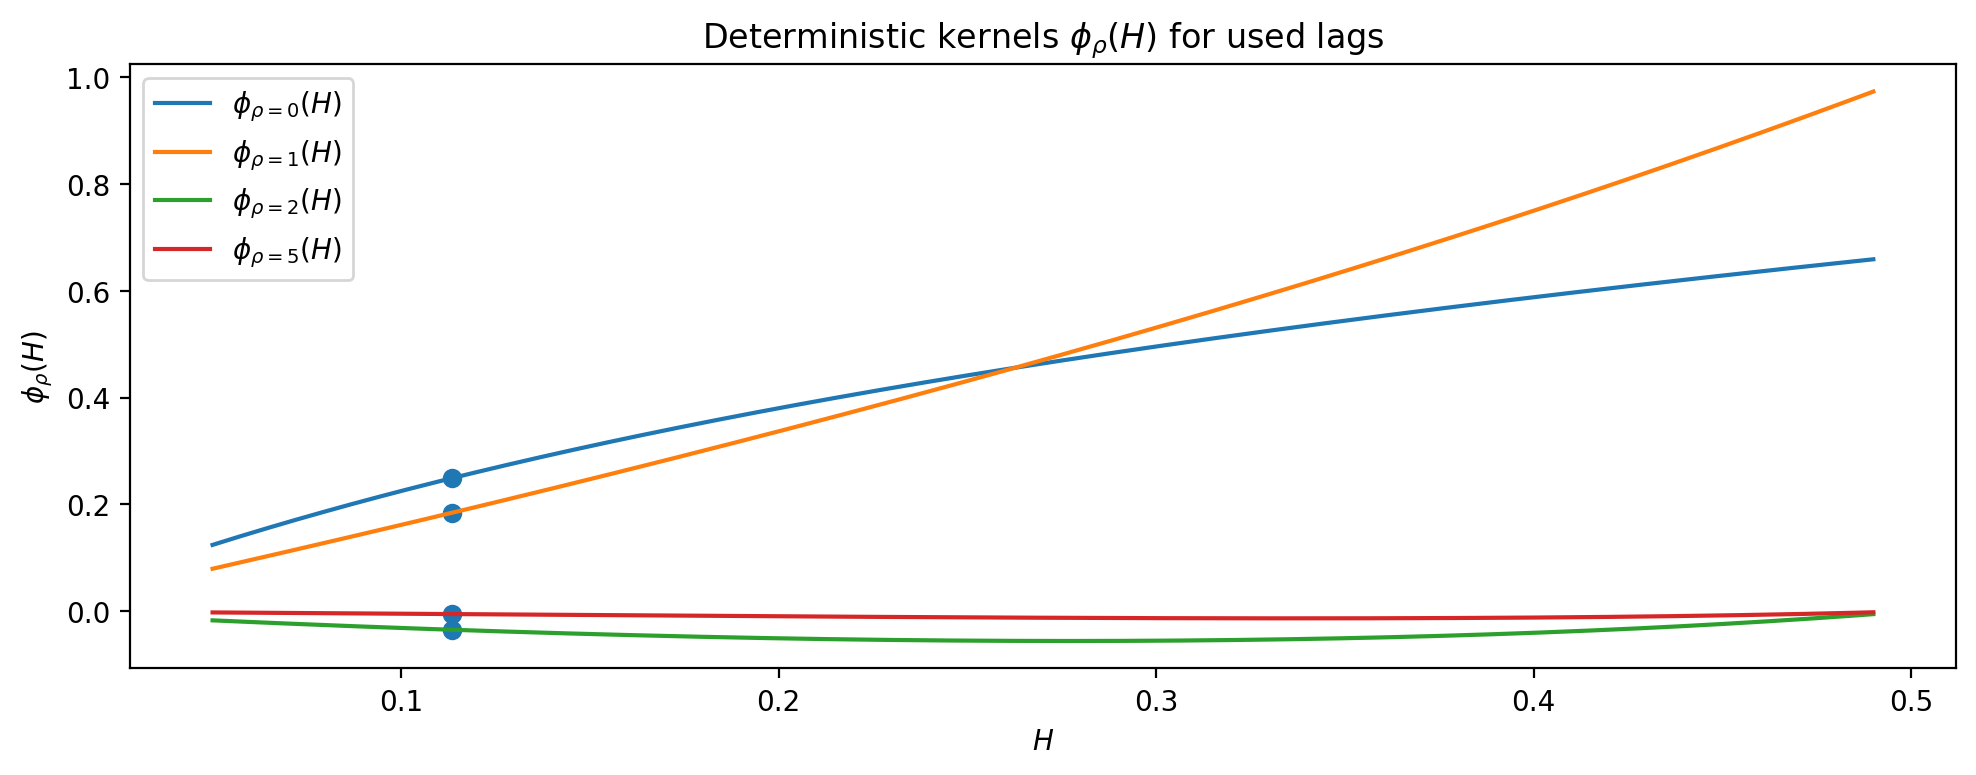

In [14]:
########################################################################
# RESULT ################################################################
########################################################################

import matplotlib.pyplot as plt
from scipy import stats  


def stem_compat(ax, x, y, **kw):
    try:
        return ax.stem(x, y, use_line_collection=True, **kw)  # newer MPL
    except TypeError:
        return ax.stem(x, y, **kw)                            # older MPL

def _phi_rho_fallback(H: float, rho: int) -> float:
    """
    5-point FD kernel for φ_ρ(H).
    """
    p = 2.0 * H + 2.0
    f = lambda x: abs(float(x)) ** p
    num = (f(rho + 2) - 4.0 * f(rho + 1) + 6.0 * f(rho) - 4.0 * f(rho - 1) + f(rho - 2))
    den = 2.0 * (2.0 * H + 1.0) * (2.0 * H + 2.0)
    return num / den

def phi_combo_fallback(H: float, rho: int) -> float:
    return _phi_rho_fallback(H, 0) + 2.0 * _phi_rho_fallback(H, 1) if rho == 1 else _phi_rho_fallback(H, rho)

def phi_vector_fallback(H: float, rhos):
    return np.asarray([phi_combo_fallback(H, r) for r in rhos], dtype=float)

def R_hat_closed_form_fallback(W: np.ndarray, rV: np.ndarray, phiH: np.ndarray) -> float:
    num = phiH.T @ W @ rV
    den = phiH.T @ W @ phiH
    return float(num / den)

def objective_for_H_fallback(H: float, rV: np.ndarray, rhos, W: np.ndarray) -> float:
    phiH = phi_vector_fallback(H, rhos)
    Rhat = R_hat_closed_form_fallback(W, rV, phiH)
    resid = rV - phiH * Rhat
    return float(resid.T @ W @ resid)

def plot_gmm_results(res, setup=None, *, save=False, prefix="gmm_plots"):
    """
    Plots:
      1) window sizes k_n and scaled k_n·mesh (mesh = δ_n or ε_n),
      2) data rV vs model φ(Ĥ)·R̂_t,
      3) residuals and studentized Z,
      4) QQ-plot of Z vs N(0,1),
      5) objective profile around Ĥ,
      6) φ_ρ(H) curves with Ĥ marker.
    """
    Hhat = float(res.H_hat)
    Rhat = float(res.R_hat)
    ks   = np.asarray(res.ks, dtype=int)

    if hasattr(res, "kn_delta"):              
        kd = np.asarray(res.kn_delta, dtype=float)
        mesh = float(res.delta_n)
        mesh_name = "delta"                   
        mesh_math = r"\delta_n"               
    else:                                     
        kd = np.asarray(res.kn_epsn, dtype=float)
        mesh = float(res.eps_n)
        mesh_name = "epsilon"
        mesh_math = r"\varepsilon_n"

    rV   = np.asarray(res.rV_vec, dtype=float)
    phiH = np.asarray(res.phi_vec_hat, dtype=float)
    Z    = np.asarray(res.Z_vec, dtype=float)

    # rhos for annotations/curves
    if setup is not None and hasattr(setup, "rhos"):
        rhos = list(setup.rhos)
    else:
        rhos = list(range(len(rV)))

    pred  = phiH * Rhat
    resid = rV - pred
    m     = len(rV)
    js    = np.arange(1, m + 1)

    #################################################################
    ################## Acquire φ ####################################
    #################################################################
    phi_combo_fn = globals().get("phi_combo", None) or phi_combo_fallback
    objective_H_fn = globals().get("objective_for_H", None) or objective_for_H_fallback


    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].bar(js, ks)
    ax[0].set_title("Window sizes $k_n$")
    ax[0].set_xlabel("Coordinate $j$")
    ax[0].set_ylabel("$k_n$")
    ax[0].set_xticks(js)

    ax[1].bar(js, kd)
    ax[1].set_title(fr"Scaled windows $k_n\,{mesh_math}$")
    ax[1].set_xlabel("Coordinate $j$")
    ax[1].set_ylabel(fr"$k_n\,{mesh_math}$")
    ax[1].set_xticks(js)
    for i, v in enumerate(kd, 1):
        ax[1].text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_windows.png", dpi=150)
    plt.show()


    width = 0.38
    fig, ax = plt.subplots(figsize=(11, 4))
    ax.bar(js - width/2, rV, width=width, label=r"$V_n^{(j)}(t)$")
    ax.bar(js + width/2, pred, width=width, label=rf"$\phi_j(\widehat{{H}})\,\widehat{{R}}_t$")
    ax.set_title(r"Data vs model: $V_n^{(j)}(t)$ vs $\phi_j(\widehat{H})\widehat{R}_t$")
    ax.set_xlabel("Coordinate $j$")
    ax.set_ylabel("Value")
    ax.set_xticks(js)
    ax.legend()
    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_fit.png", dpi=150)
    plt.show()

    fig, ax = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

    stem_compat(ax[0], js, resid, basefmt=" ", linefmt="-", markerfmt="o")
    ax[0].set_title(r"Raw residuals $V_n^{(j)}(t) - \phi_j(\widehat{H})\widehat{R}_t$")
    ax[0].set_ylabel("Residual")

    stem_compat(ax[1], js, Z, basefmt=" ", linefmt="-", markerfmt="o")
    ax[1].hlines([0], js.min()-0.5, js.max()+0.5, linestyles="dashed")
    ax[1].set_title(
        rf"Studentized $Z_t^{{n,j}}=(k_n\,{mesh_math})^{{\frac{{1}}{{2}}-2\widehat{{H}}}}"
        r"(V_n^{(j)}-\phi_j(\widehat{H})\widehat{R}_t)$"
    )
    ax[1].set_xlabel("Coordinate $j$")
    ax[1].set_ylabel(r"$Z_t^{n,j}$")
    ax[1].set_xticks(js)

    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_residuals_Z.png", dpi=150)
    plt.show()

    fig = plt.figure(figsize=(5, 5))
    stats.probplot(Z, dist="norm", plot=plt)
    plt.title(r"QQ plot of $Z_t^{n,j}$ vs $\mathcal{N}(0,1)$")
    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_qq.png", dpi=150)
    plt.show()

    H_lo = max(0.05, Hhat - 0.15)
    H_hi = min(0.49, Hhat + 0.15)
    H_grid = np.linspace(H_lo, H_hi, 401)
    obj = [objective_H_fn(h, rV, rhos, np.eye(m)) for h in H_grid]

    plt.figure(figsize=(10, 4))
    plt.plot(H_grid, obj)
    plt.axvline(Hhat, linestyle="--")
    plt.title(r"Objective profile $\|V_n(t)-\phi(H)R(H)\|^2$ over $H$")
    plt.xlabel(r"$H$")
    plt.ylabel("Objective")
    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_objective.png", dpi=150)
    plt.show()

    Hs = np.linspace(0.05, 0.49, 300)
    Phi_curves = np.vstack([[phi_combo_fn(h, r) for h in Hs] for r in rhos])
    plt.figure(figsize=(10, 4))
    for i, r in enumerate(rhos):
        plt.plot(Hs, Phi_curves[i, :], label=rf"$\phi_{{\rho={r}}}(H)$")
    vals_at_hat = [phi_combo_fn(Hhat, r) for r in rhos]
    plt.scatter([Hhat] * len(rhos), vals_at_hat)
    plt.title(r"Deterministic kernels $\phi_\rho(H)$ for used lags")
    plt.xlabel(r"$H$")
    plt.ylabel(r"$\phi_\rho(H)$")
    plt.legend()
    plt.tight_layout()
    if save: plt.savefig(f"{prefix}_phi_curves.png", dpi=150)
    plt.show()


try:
    get_ipython()  
    import matplotlib_inline.backend_inline as _bi
    _bi.set_matplotlib_formats('retina')
except Exception:
    pass

if "res" not in globals():
    raise NameError("`res` is not defined. Run the estimator first to create `res`.")
_plot_setup = setup if "setup" in globals() else None

plot_gmm_results(res, _plot_setup, save=False)
